In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tsai.all import *
from utils import *
from scipy.stats import norm
from scipy.special import kl_div
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal


## Read data

In [34]:
# Load data
error_signal, tc = read_data_participant(r'/home/mihai/Thesis/Data/Clean_CSV_data/David_Li_CSV_data/PreviewDistractionExpData_S1/PRDCE/e.csv')
u_signal, _ = read_data_participant(r'/home/mihai/Thesis/Data/Clean_CSV_data/David_Li_CSV_data/PreviewDistractionExpData_S1/PRDCE/u.csv')

error_signal_test =  error_signal[9000:]
u_signal_test = u_signal[9000:] 
tc_test = tc[9000:]

error_signal = error_signal[0:9000]
u_signal = u_signal[0:9000]
tc = tc[0:9000] 

In [35]:
error_distracted = error_signal[tc == 1]
error_not_distracted = error_signal[tc == 0]

u_distracted = u_signal[tc == 1]
u_not_distracted = u_signal[tc == 0]

## Estimate piors' PDFs and Visualize

In [36]:
def estimate_distribution_single(data, bandwidth=0.1):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data[:, None])
    return kde

# Function to visualize KDE and histogram for any signal
def plot_kde_histogram(data, title, color='lightblue', kde_color='red', bandwidth=0.2, bins=30):
    """
    Plots a histogram with KDE overlay for the given data.
    
    Parameters:
    data (numpy array): Input signal data to plot.
    title (str): Title of the plot.
    color (str): Color of the histogram.
    kde_color (str): Color of the KDE plot.
    bandwidth (float): Bandwidth for the KDE.
    bins (int): Number of bins in the histogram.
    """
    # Step 1: Plot histogram
    plt.hist(data, bins=bins, density=True, alpha=0.5, color=color, label='Histogram')

    # Step 2: Estimate the KDE
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data[:, None])

    # Create an array of values where KDE will be evaluated
    x_vals = np.linspace(data.min(), data.max(), 1000)

    # Step 3: Evaluate the KDE to get the probability densities
    log_density = kde.score_samples(x_vals[:, None])  # Returns log of density
    density = np.exp(log_density)  # Convert log density back to normal density

    # Step 4: Plot the KDE on top of the histogram
    plt.plot(x_vals, density, color=kde_color, label='KDE', linewidth=2)

    # Add labels and title
    plt.xlabel('Signal Values')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()

    # Show the plot
    plt.show()

In [37]:
def fit_gaussian(data):
    """
    Fit a multivariate Gaussian to the data.
    
    Parameters:
    data (array-like): 2D array of shape (n_samples, n_features).
    
    Returns:
    tuple: Mean vector and covariance matrix of the Gaussian.
    """
    mean = np.mean(data, axis=0)
    std_val = np.std(data)
    return mean, std_val

def plot_gaussian_1d(data, mean, std_dev, color='red', title='1D Gaussian Fit'):
    """
    Plot a 1D Gaussian distribution on top of the data histogram.
    
    Parameters:
    data (array-like): The original data used to fit the Gaussian.
    mean (float): Mean of the Gaussian.
    std_dev (float): Standard deviation of the Gaussian.
    color (str): Color for the Gaussian curve.
    """
    # Create a range of x values
    x = np.linspace(min(data), max(data), 1000)
    
    # Get the corresponding y values for the Gaussian PDF
    gaussian_pdf = norm.pdf(x, mean, std_dev)
    print(mean)
    # Plot the data histogram
    plt.hist(data, bins=30, density=True, alpha=0.6, color='blue')
    
    # Plot the Gaussian curve
    plt.plot(x, gaussian_pdf, color=color, lw=2)
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Probability Density')
    plt.show()


## Plot the fitted Gaussians

-0.04022140865698349


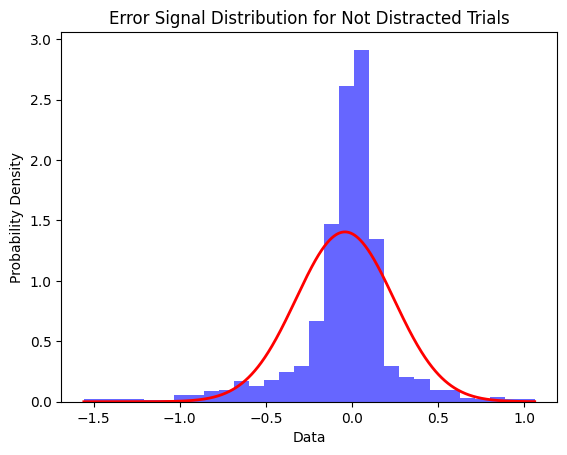

-0.0680037775079735


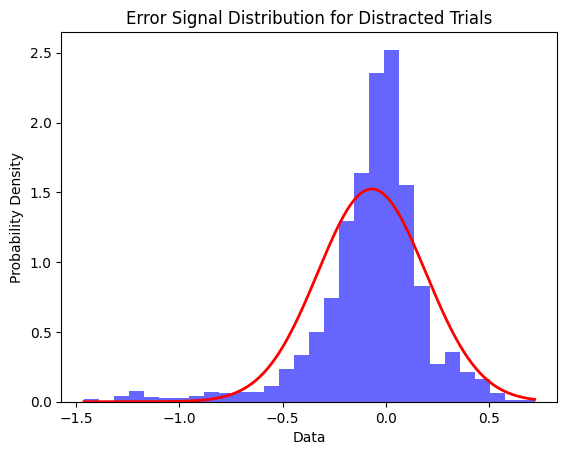

-0.05185343256785086


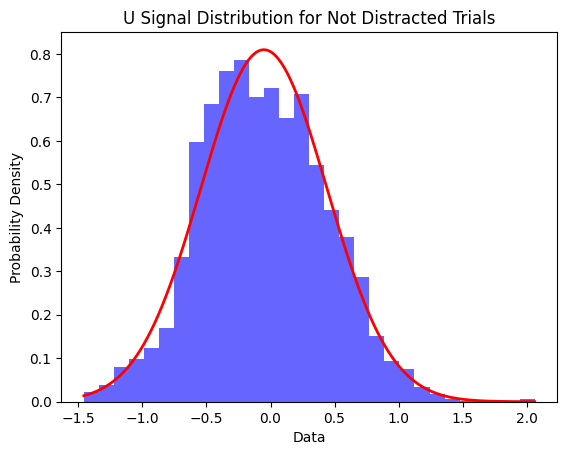

0.1579488133671907


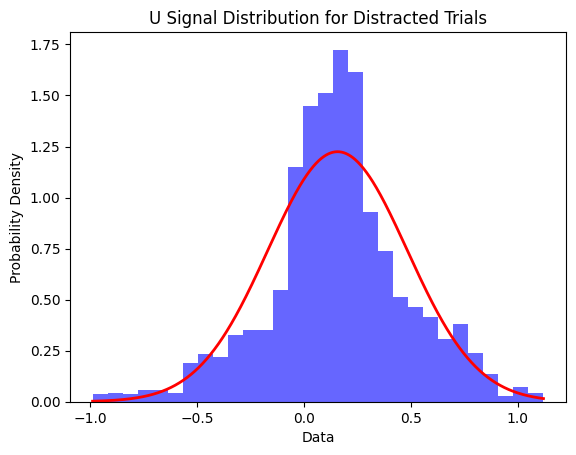

In [38]:
# Fit a Gaussian to the error signal data
error_distracted_distribution = fit_gaussian(error_distracted)
error_not_distracted_distribution = fit_gaussian(error_not_distracted)

# Plot the Gaussian on top of the histogram and KDE for distracted data
plot_gaussian_1d(error_not_distracted, error_not_distracted_distribution[0], error_not_distracted_distribution[1], color='red', title='Error Signal Distribution for Not Distracted Trials')
plot_gaussian_1d(error_distracted, error_distracted_distribution[0], error_distracted_distribution[1], color='red', title='Error Signal Distribution for Distracted Trials')

u_distracted_distribution = fit_gaussian(u_distracted)
u_not_distracted_distribution = fit_gaussian(u_not_distracted)

# Plot the Gaussian on top of the histogram and KDE for distracted data
plot_gaussian_1d(u_not_distracted, u_not_distracted_distribution[0], u_not_distracted_distribution[1], color='red', title='U Signal Distribution for Not Distracted Trials')
plot_gaussian_1d(u_distracted, u_distracted_distribution[0], u_distracted_distribution[1], color='red', title='U Signal Distribution for Distracted Trials')

## Plot fitted KDEs

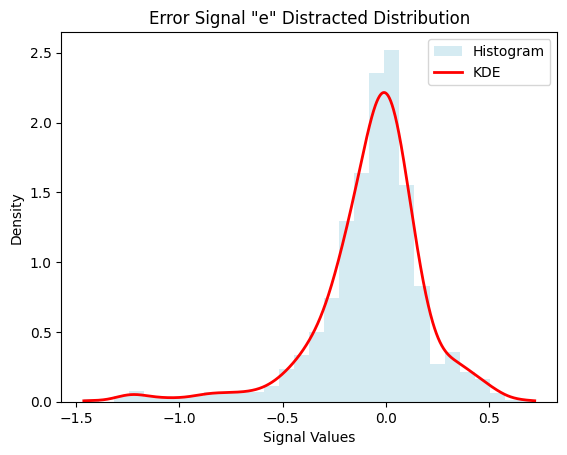

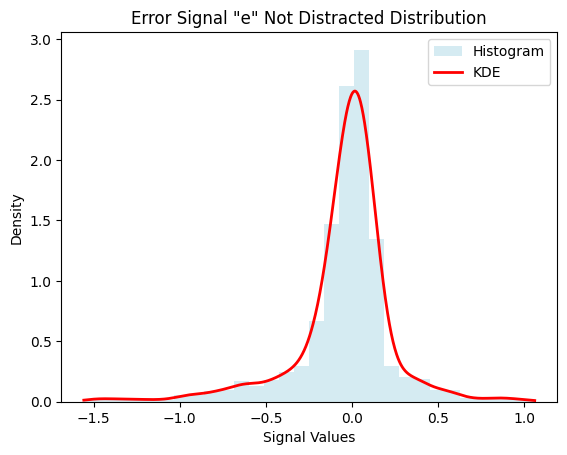

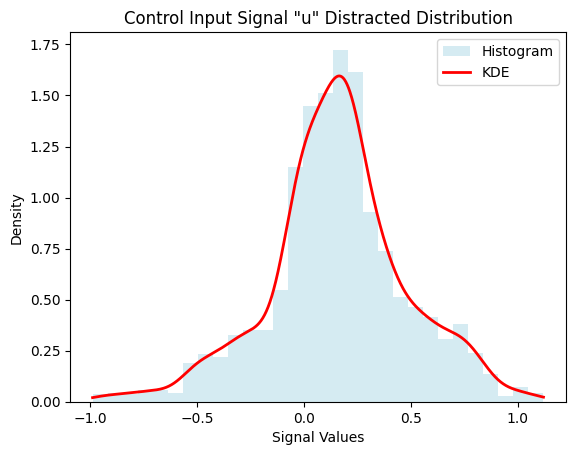

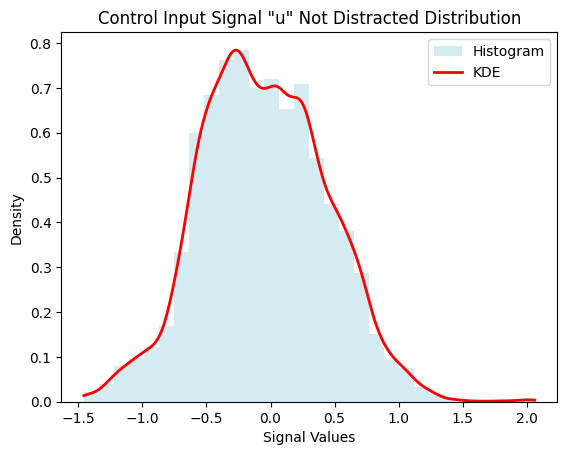

In [39]:

# Visualize the error_signal
plot_kde_histogram(error_distracted, title='Error Signal "e" Distracted Distribution', bandwidth=0.07)

# Visualize the control input signal (u_signal)
plot_kde_histogram(error_not_distracted, title='Error Signal "e" Not Distracted Distribution', bandwidth=0.07)

plot_kde_histogram(u_distracted, title='Control Input Signal "u" Distracted Distribution', bandwidth=0.07)

plot_kde_histogram(u_not_distracted, title='Control Input Signal "u" Not Distracted Distribution', bandwidth=0.07)

## Generate windowed data

In [40]:
def create_windows(data, window_size=100, overlap=0.5):
    """
    Creates windows of the given data with the specified window size and overlap.
    
    Parameters:
    data (numpy array): Input signal data.
    window_size (int): Size of the window.
    overlap (float): Overlap between windows (0 to 1).
    
    Returns:
    numpy array: Array of windows with the given size and overlap.
    """
    step = int(window_size * (1 - overlap))
    return np.array([data[i:i + window_size] for i in range(0, len(data) - window_size + 1, step)])

error_test_windows =  create_windows(error_signal_test, window_size=100, overlap=0.5)
u_test_windows = create_windows(u_signal_test, window_size=100, overlap=0.5)

data_window = np.stack((error_test_windows, u_test_windows), axis=2)

tc_windows = create_windows(tc_test, window_size=100, overlap=0.5)

In [41]:
input_distracted = np.column_stack((error_distracted, u_distracted))  # Distracted data
input_not_distracted = np.column_stack((error_not_distracted, u_not_distracted))  # Non-distracted data

## Compare and classify incoming windows with prior data

In [42]:
def count_distractions(window):
    return np.sum(window, axis=1)

error_test_windows_count = count_distractions(tc_windows)

In [43]:
input_distracted = np.column_stack((error_distracted, u_distracted))  # Distracted data
input_not_distracted = np.column_stack((error_not_distracted, u_not_distracted))  # Non-distracted data

def estimate_distribution(data, bandwidth=0.1):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data)
    return kde

print(input_distracted.shape)

# Fit KDEs for distracted and non-distracted states using the 2D data
kde_distracted = estimate_distribution(input_distracted, bandwidth=0.07)
kde_not_distracted = estimate_distribution(input_not_distracted, bandwidth=0.07)

(9287, 2)


## Classify windows methods

data_window.shape=(100, 2); tc_window.shape=(100,)


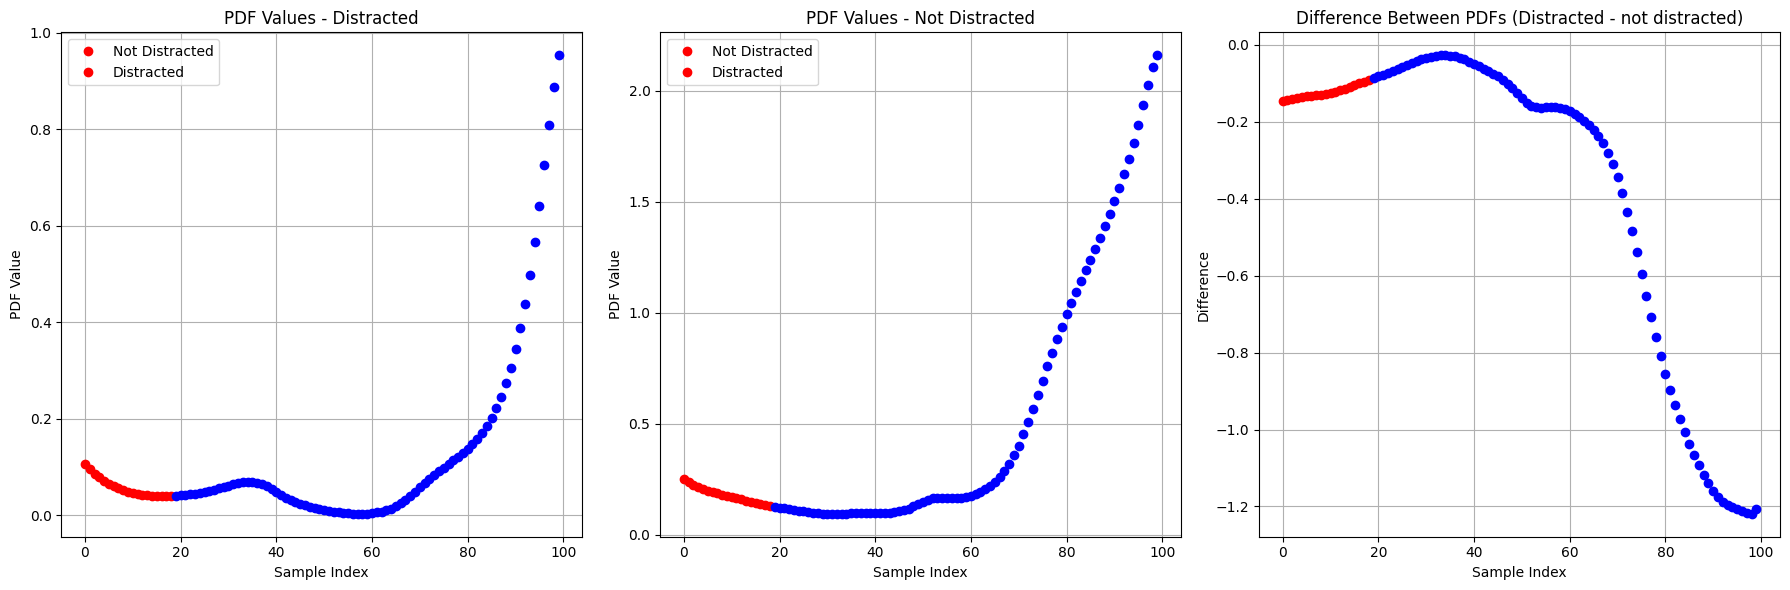

data_window.shape=(100, 2); tc_window.shape=(100,)


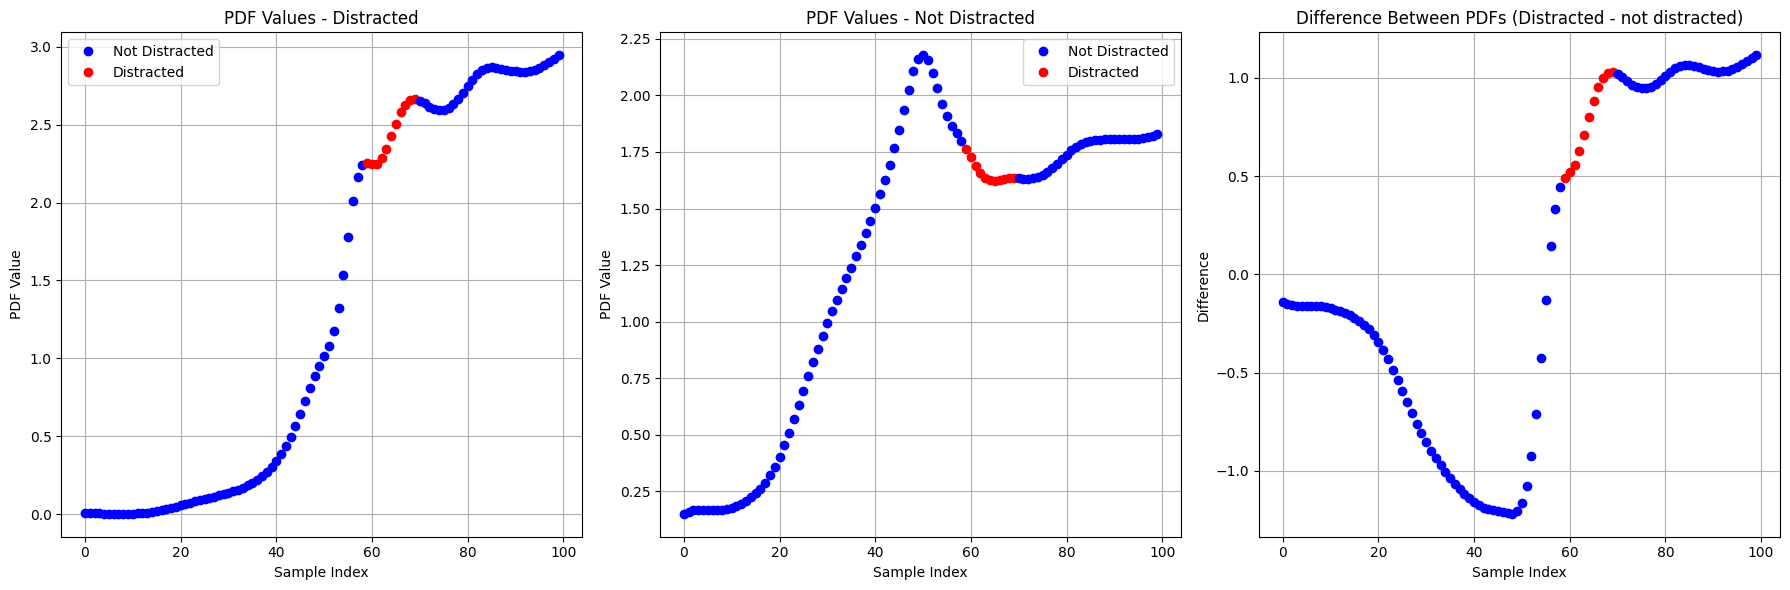

data_window.shape=(100, 2); tc_window.shape=(100,)


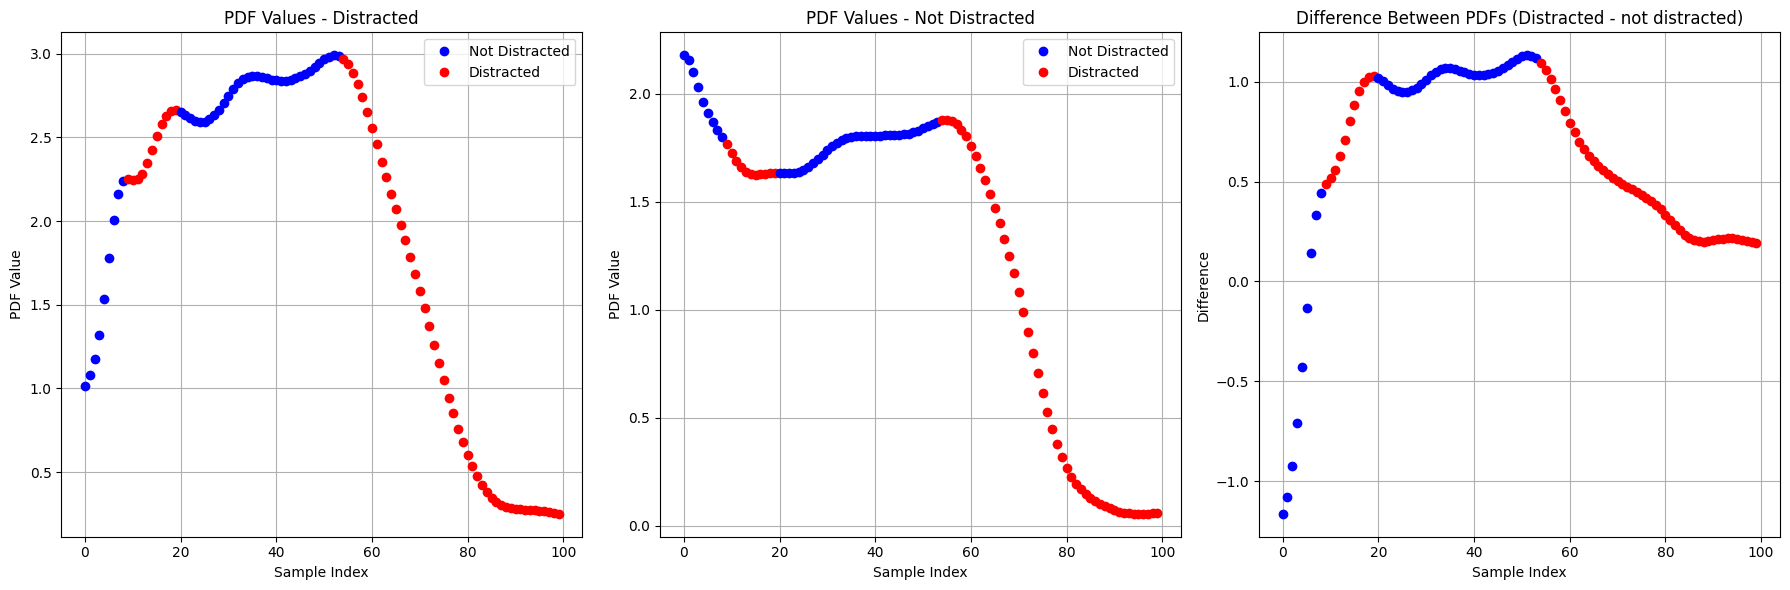

data_window.shape=(100, 2); tc_window.shape=(100,)


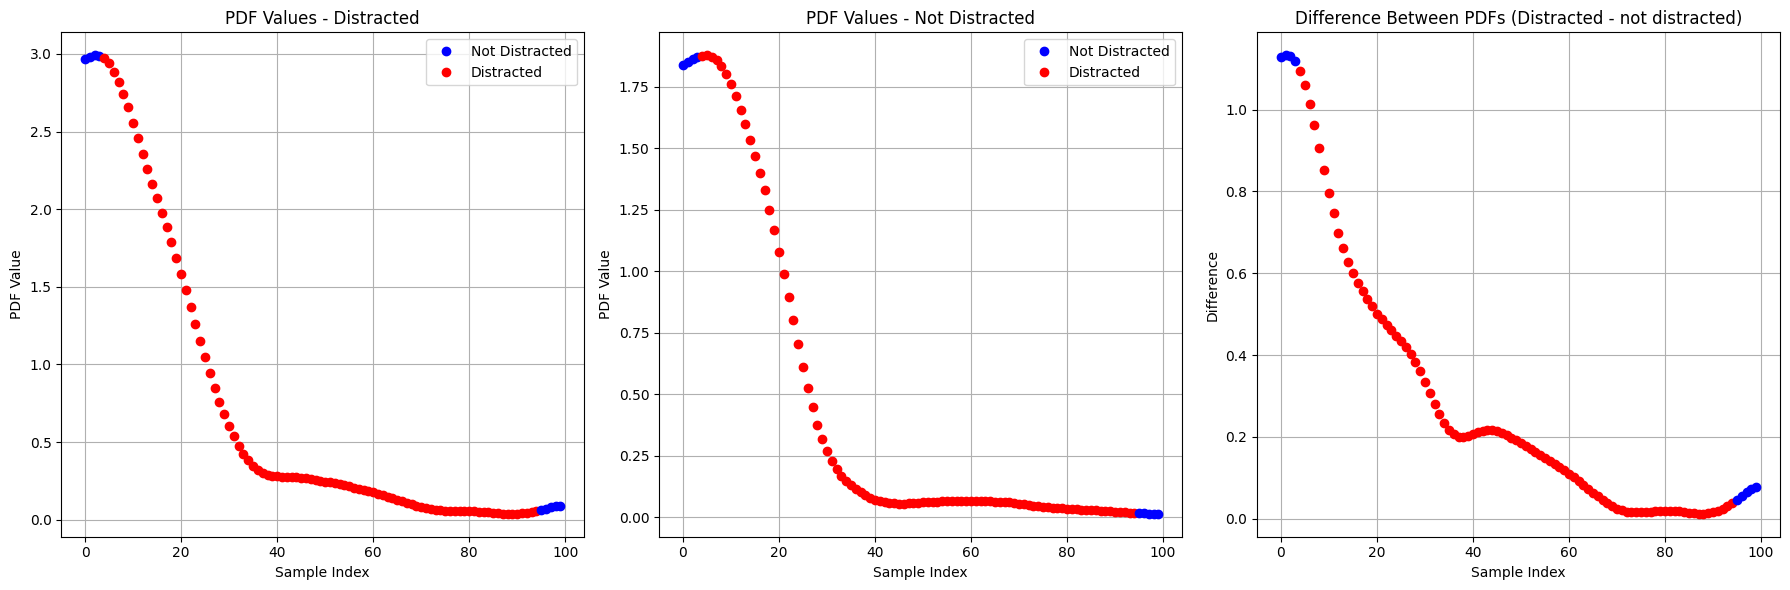

data_window.shape=(100, 2); tc_window.shape=(100,)


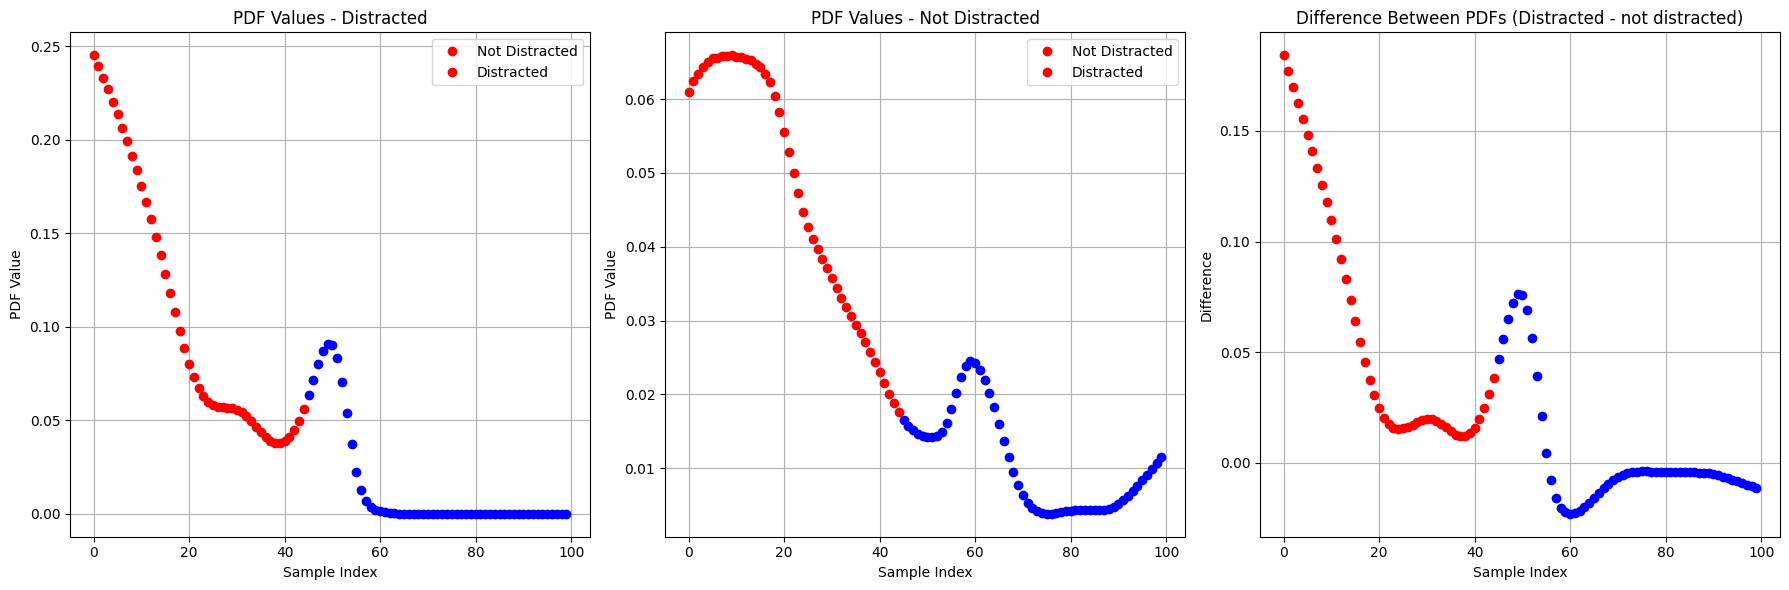

data_window.shape=(100, 2); tc_window.shape=(100,)


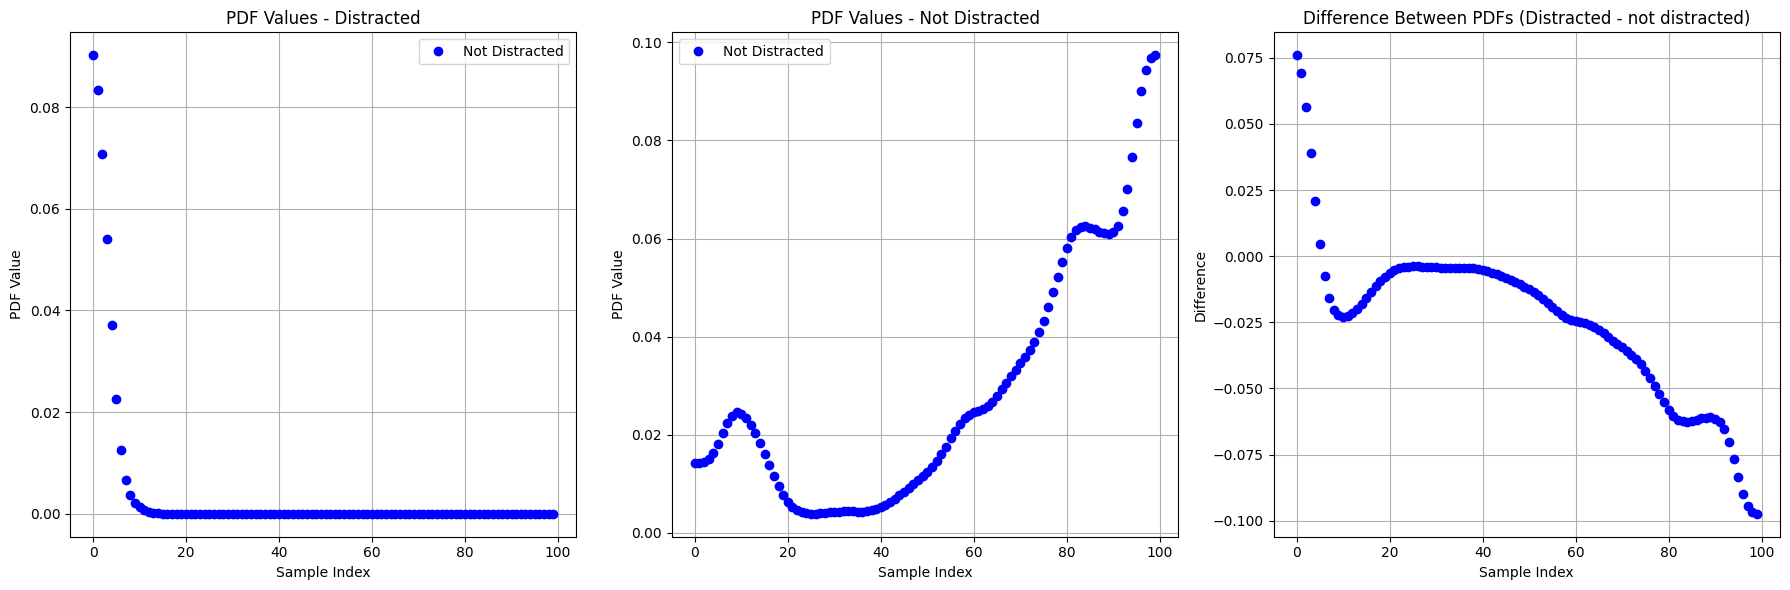

data_window.shape=(100, 2); tc_window.shape=(100,)


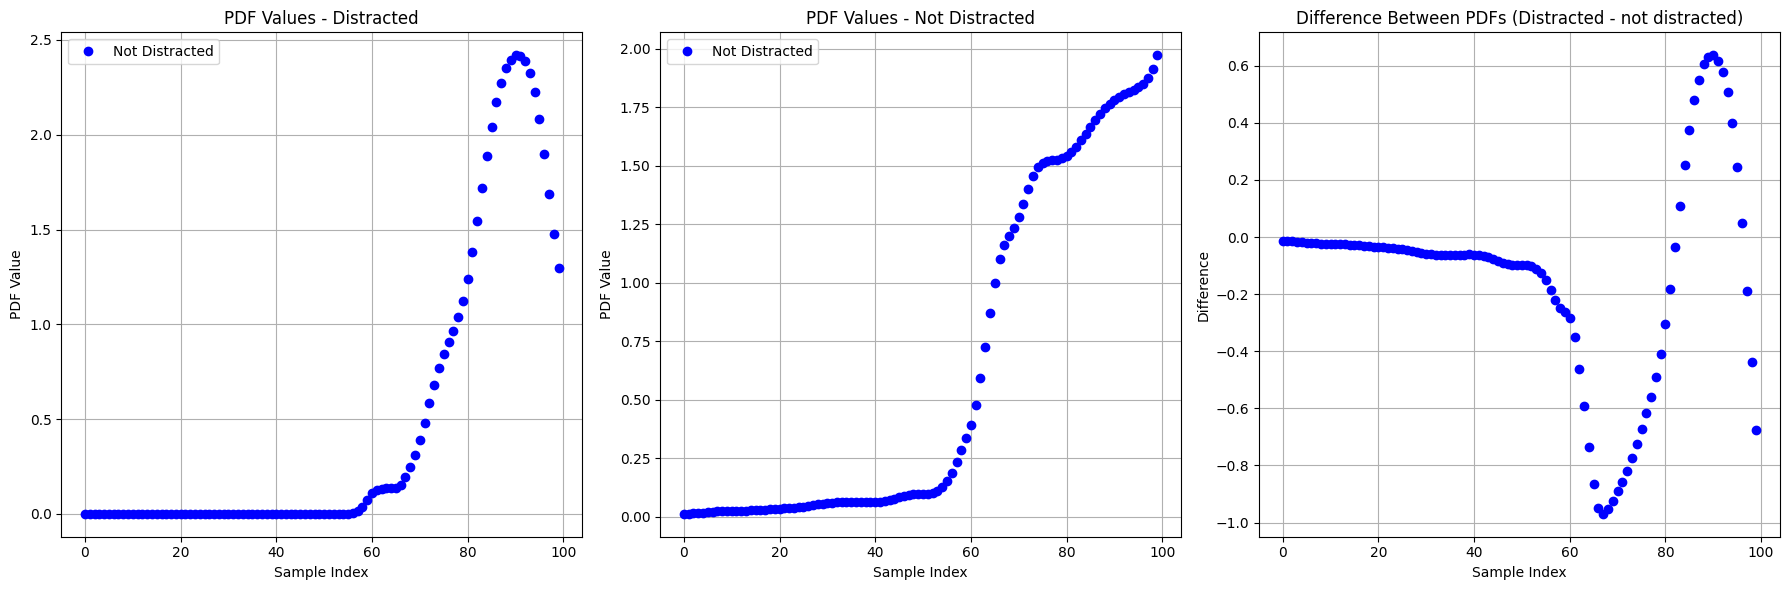

data_window.shape=(100, 2); tc_window.shape=(100,)


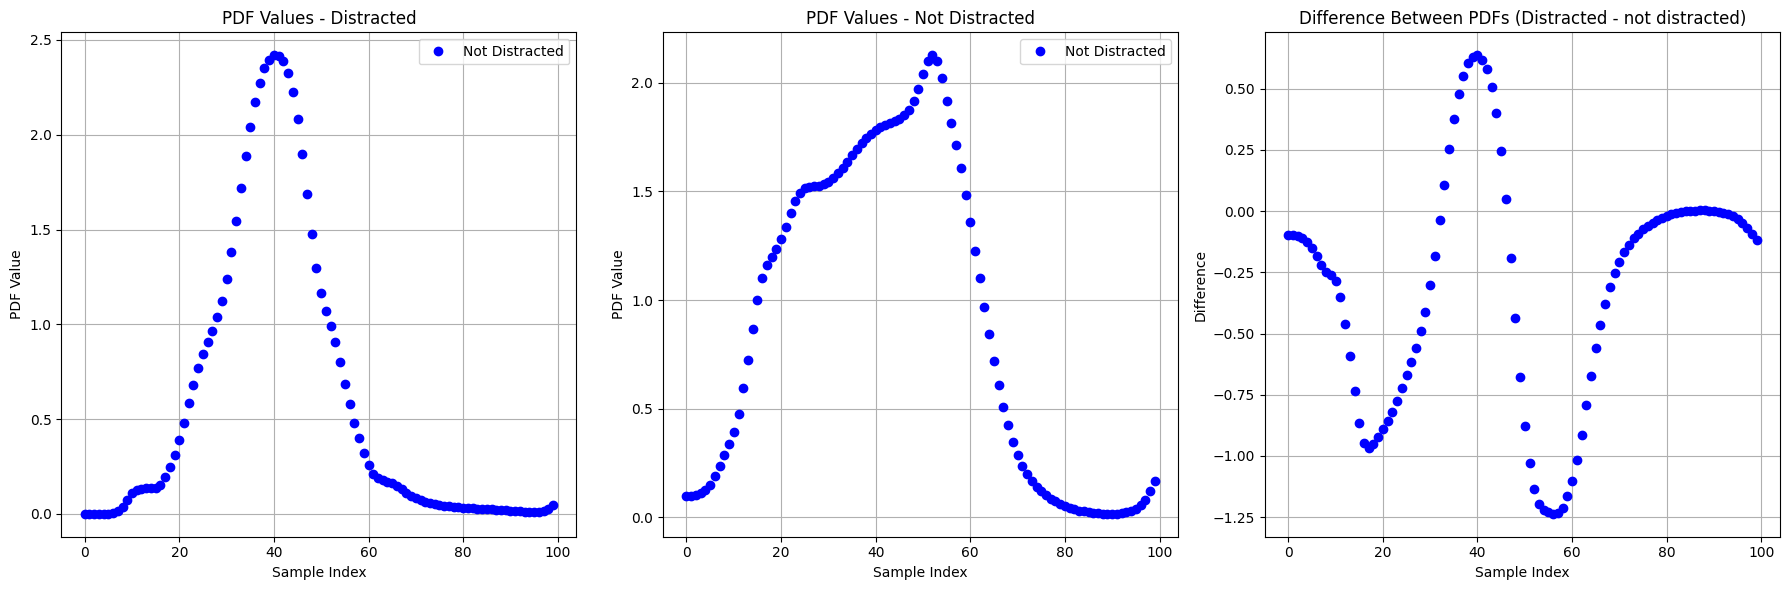

data_window.shape=(100, 2); tc_window.shape=(100,)


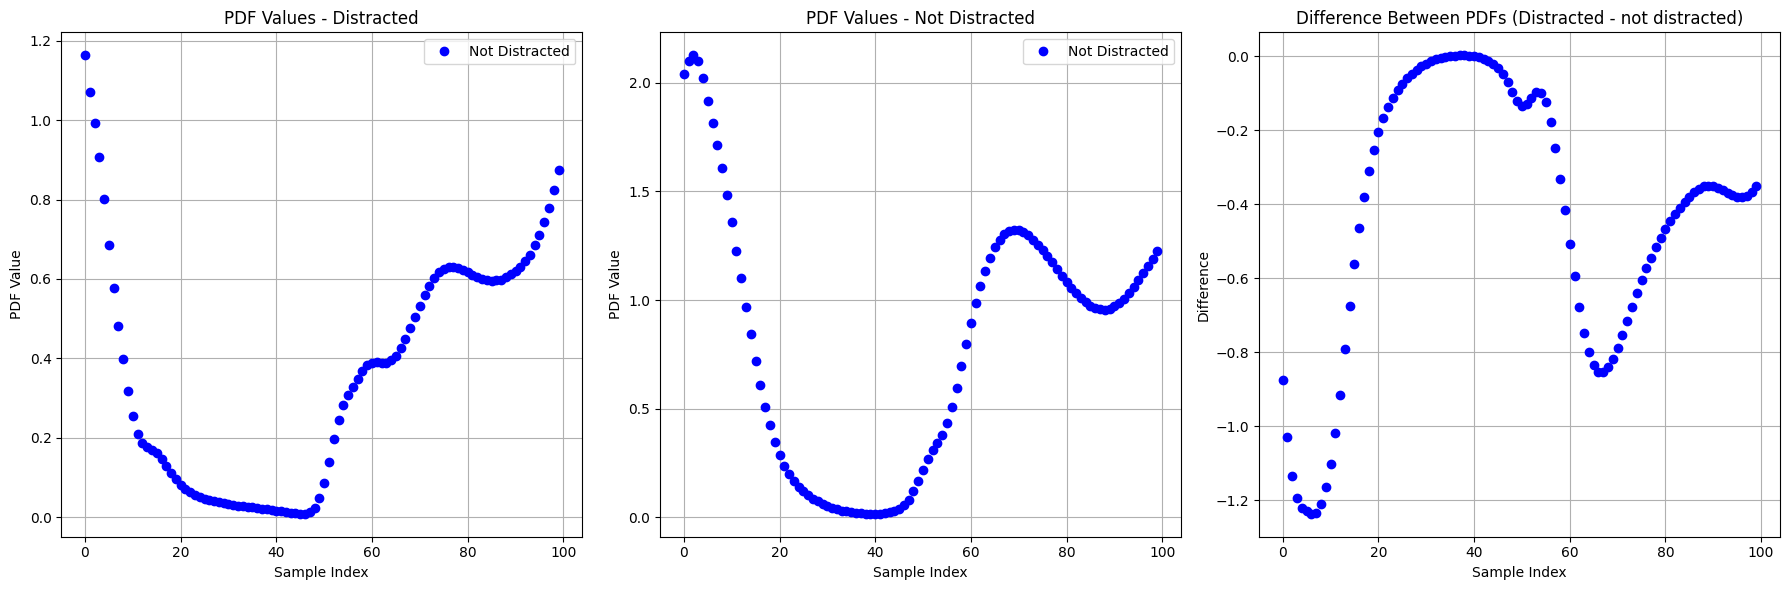

data_window.shape=(100, 2); tc_window.shape=(100,)


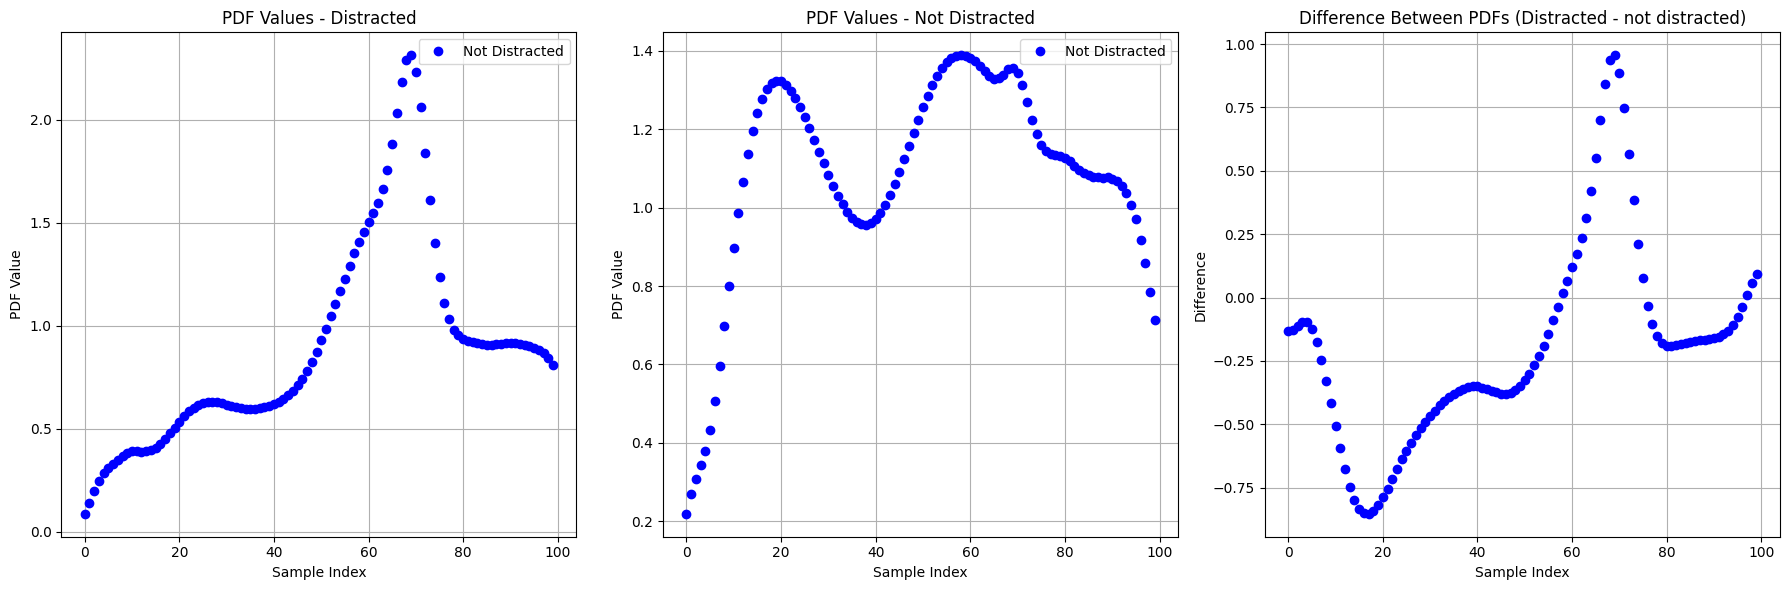

data_window.shape=(100, 2); tc_window.shape=(100,)


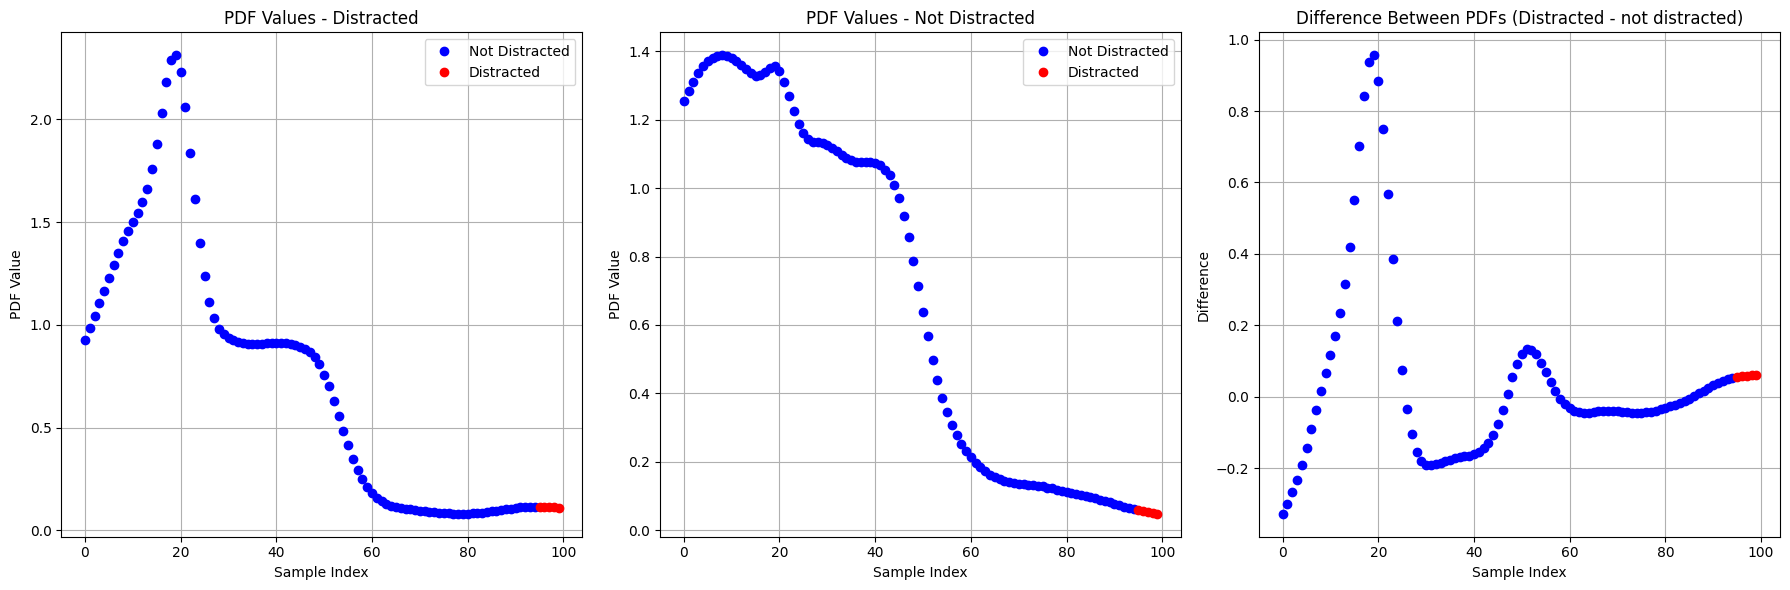

data_window.shape=(100, 2); tc_window.shape=(100,)


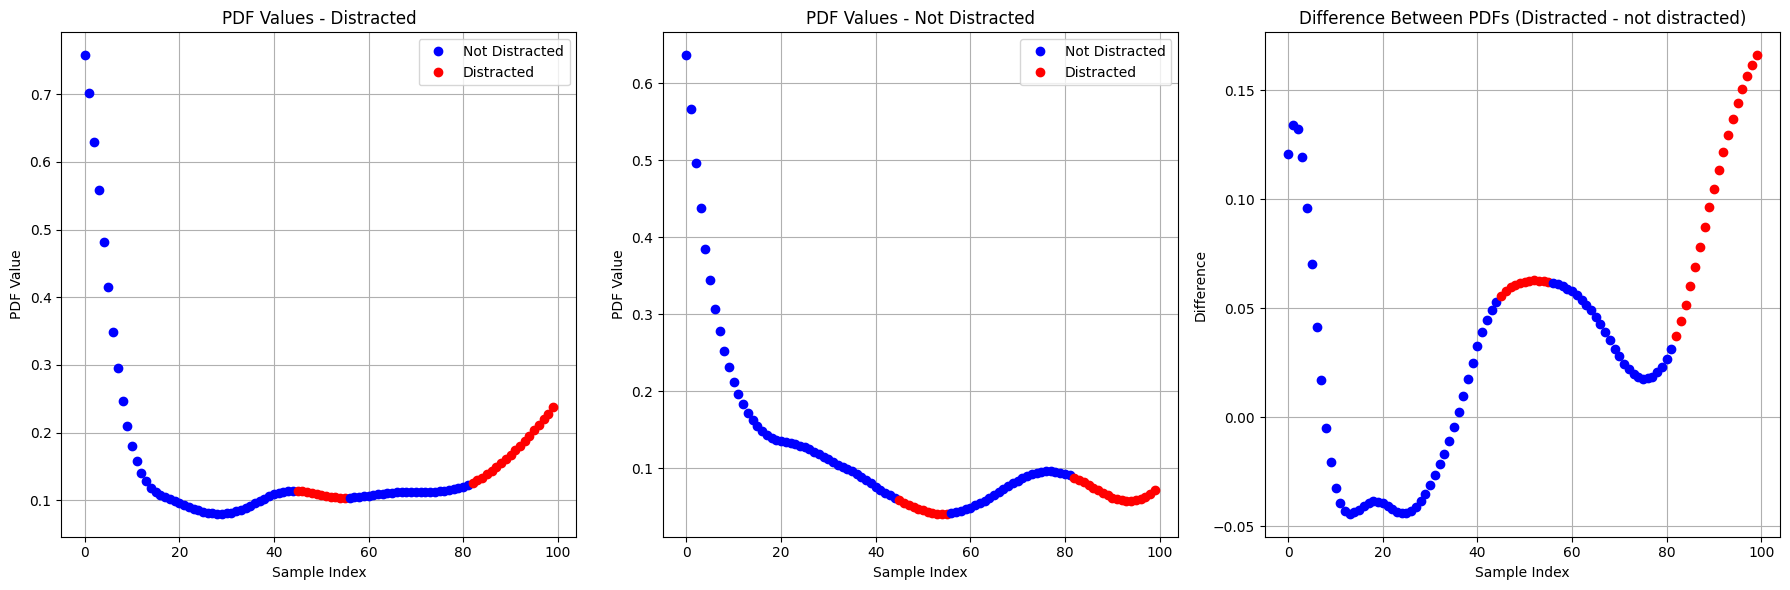

data_window.shape=(100, 2); tc_window.shape=(100,)


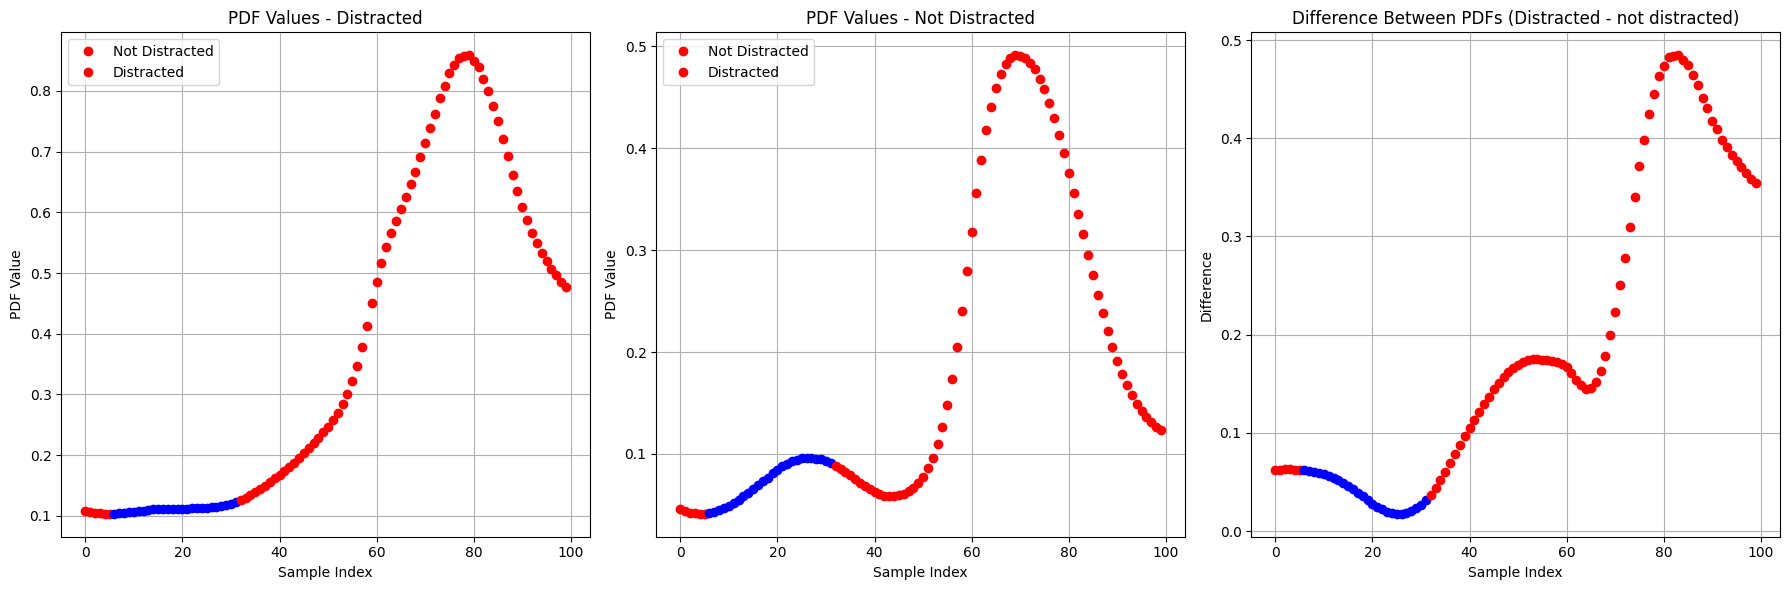

data_window.shape=(100, 2); tc_window.shape=(100,)


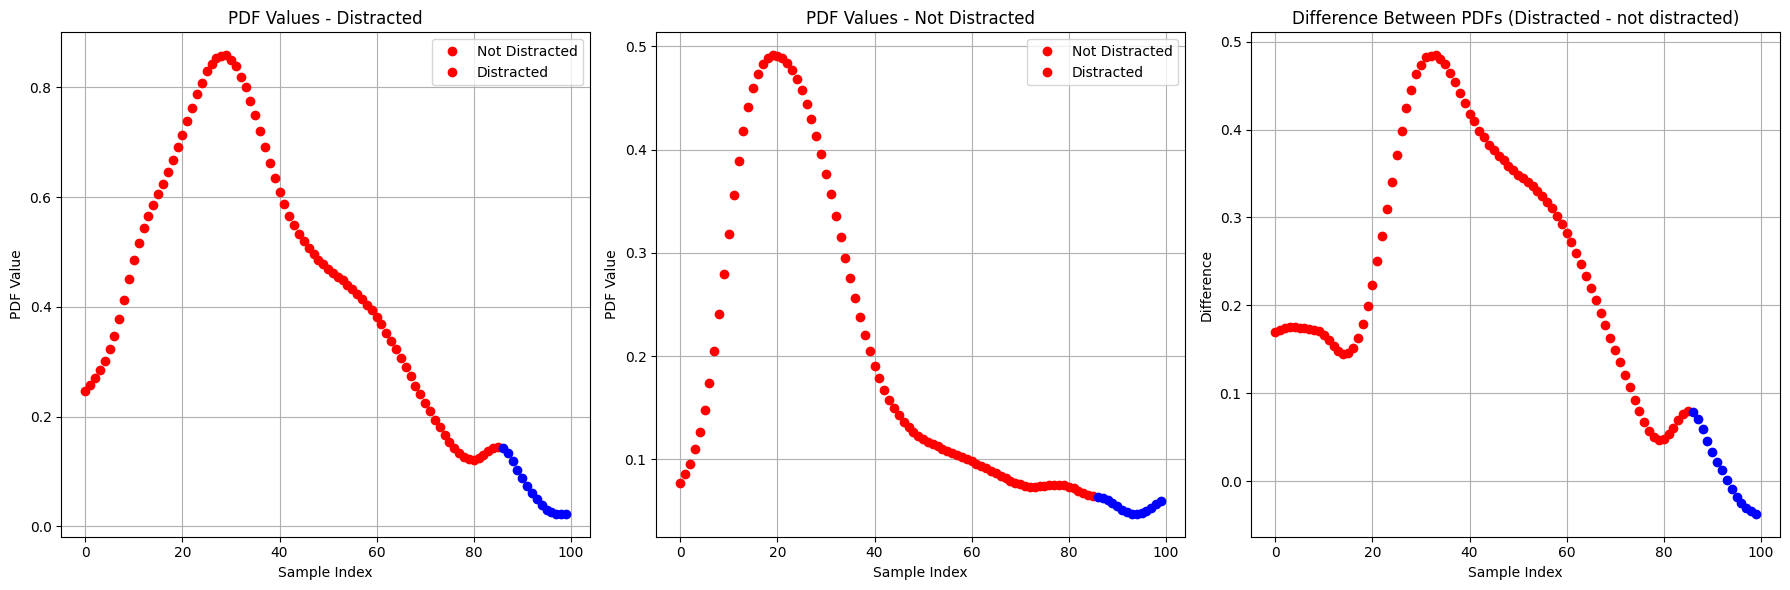

data_window.shape=(100, 2); tc_window.shape=(100,)


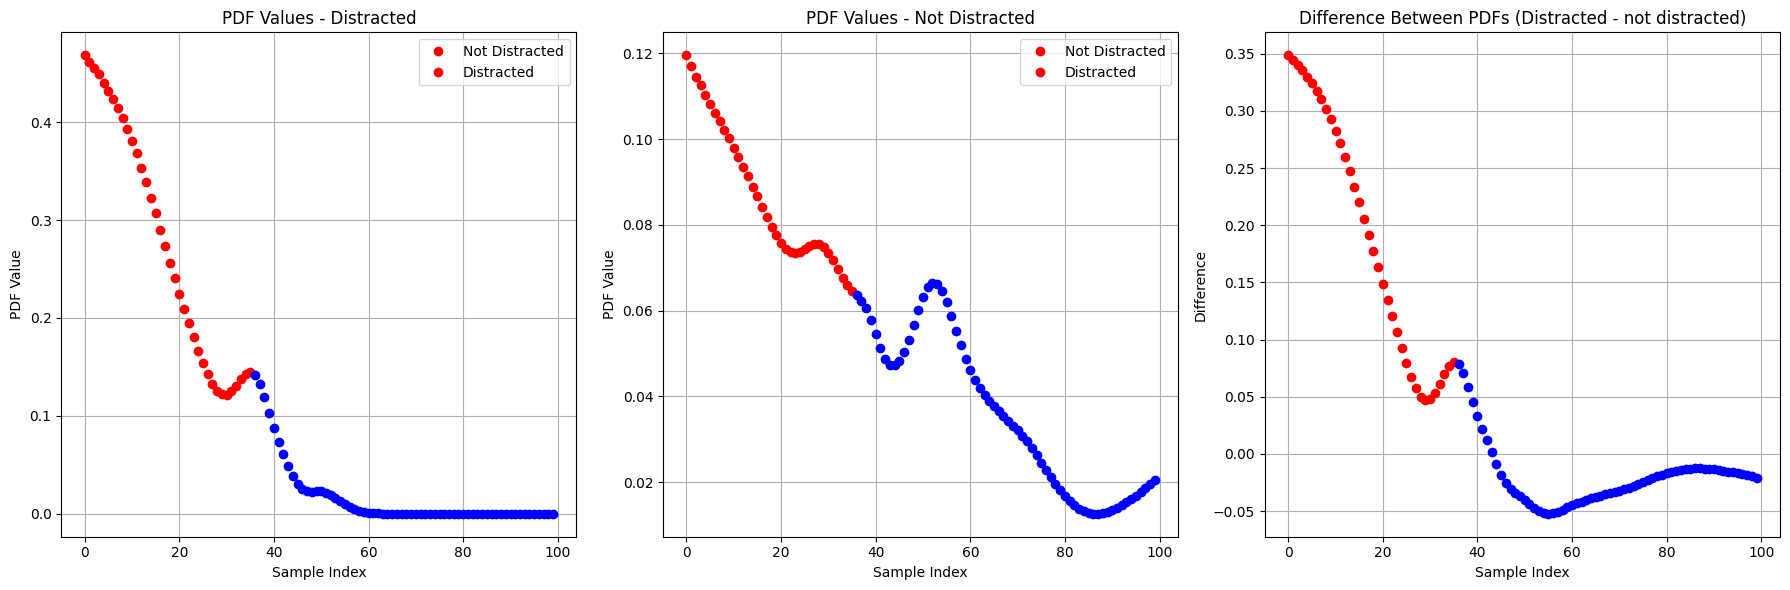

data_window.shape=(100, 2); tc_window.shape=(100,)


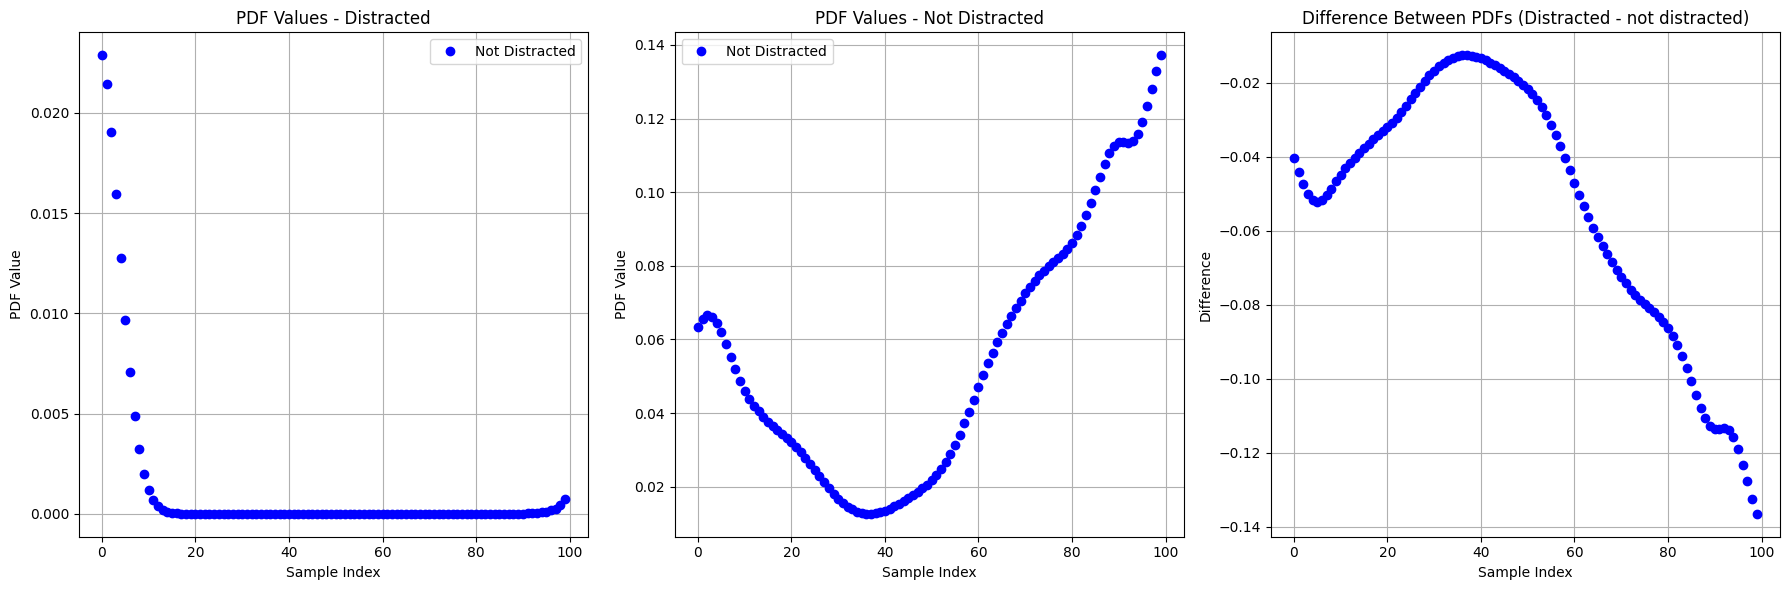

data_window.shape=(100, 2); tc_window.shape=(100,)


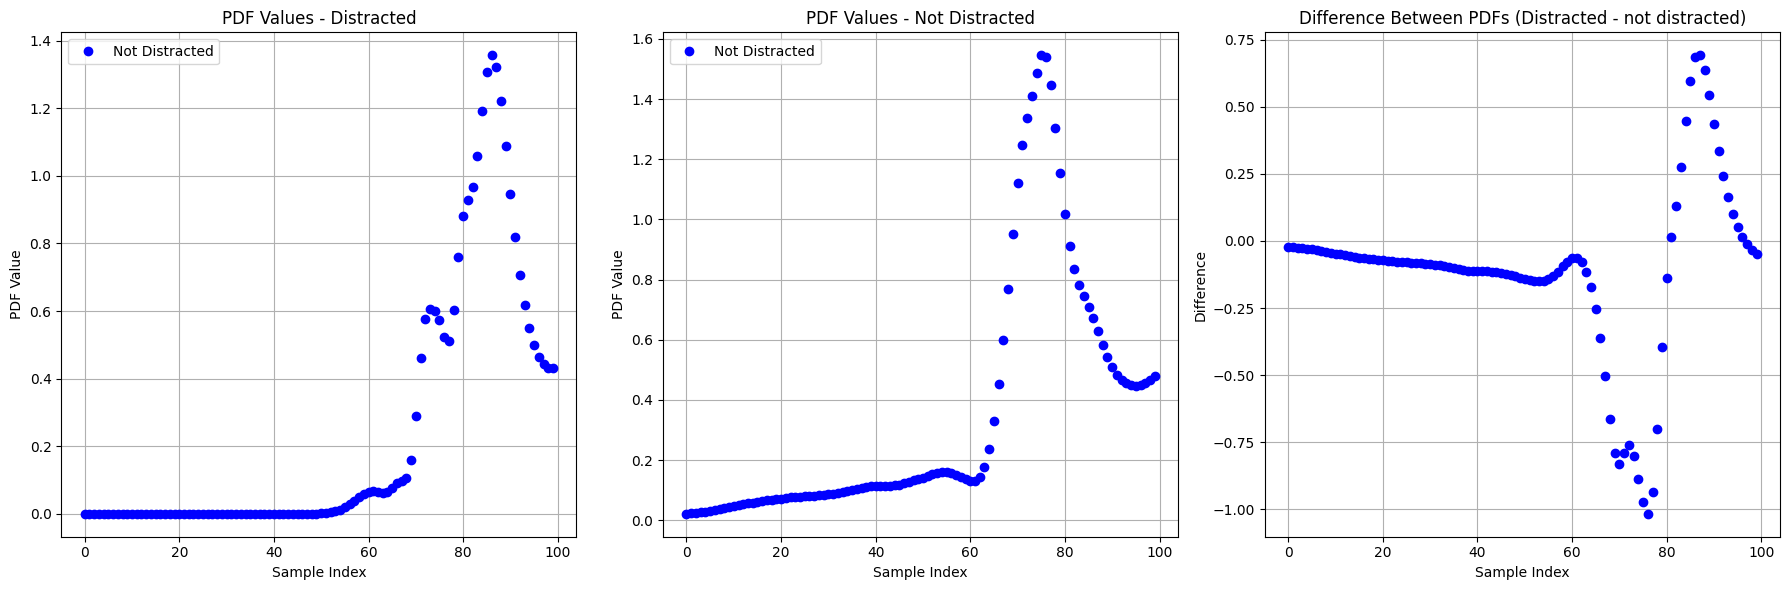

data_window.shape=(100, 2); tc_window.shape=(100,)


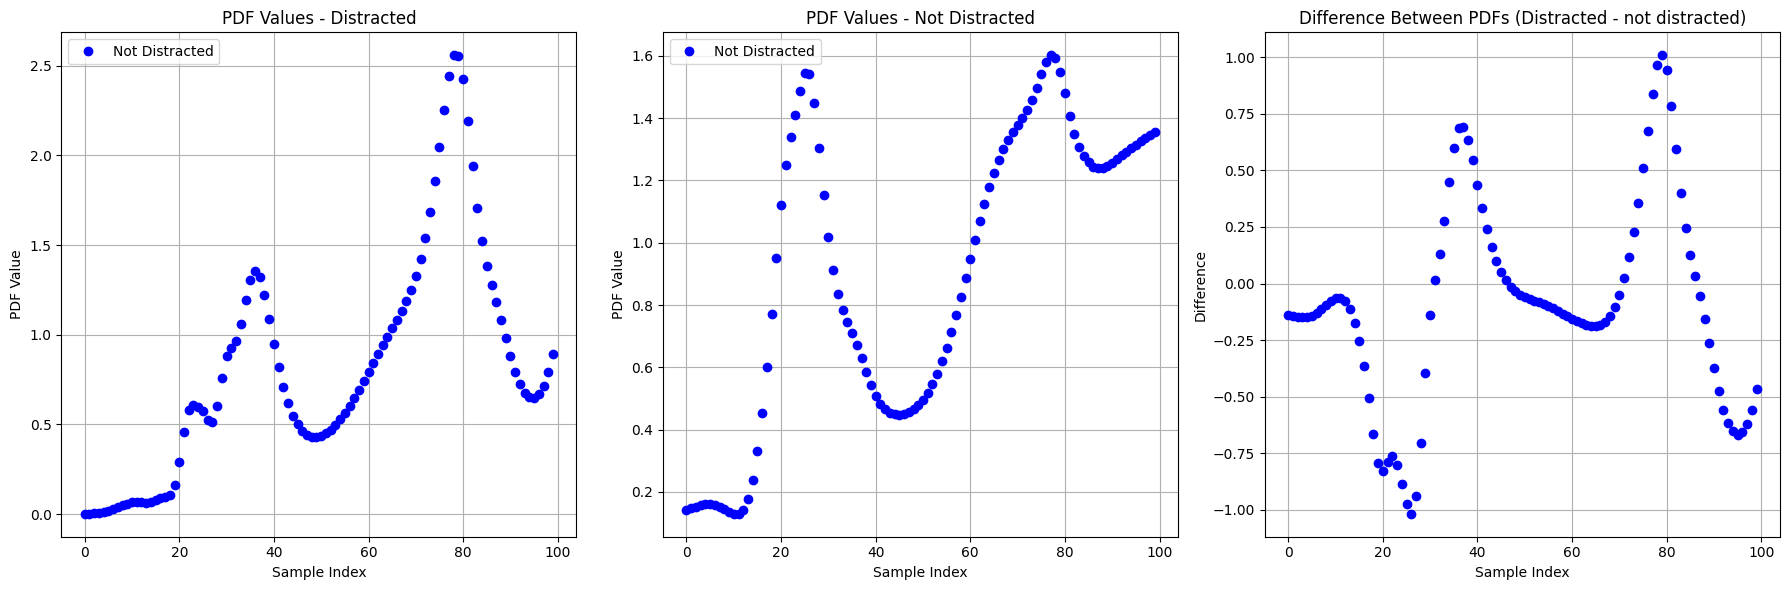

data_window.shape=(100, 2); tc_window.shape=(100,)


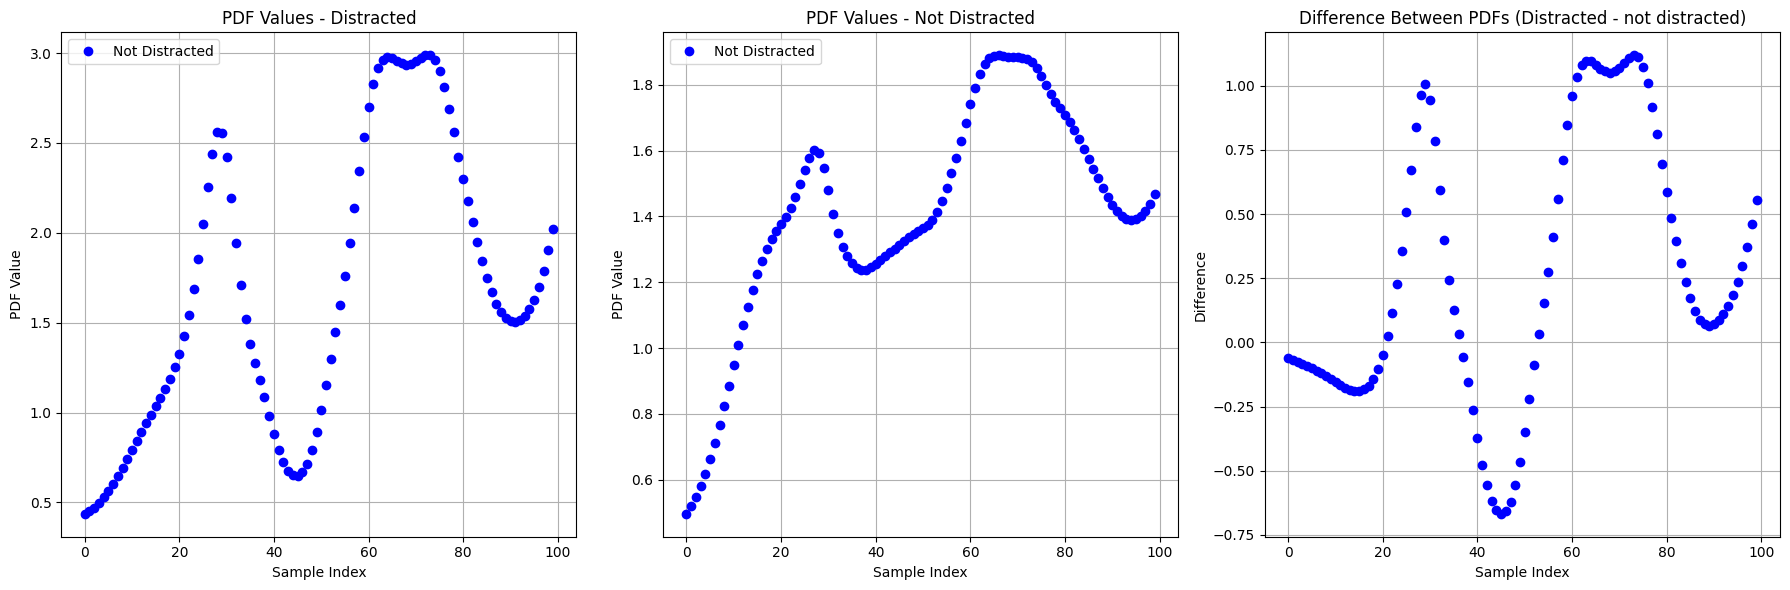

data_window.shape=(100, 2); tc_window.shape=(100,)


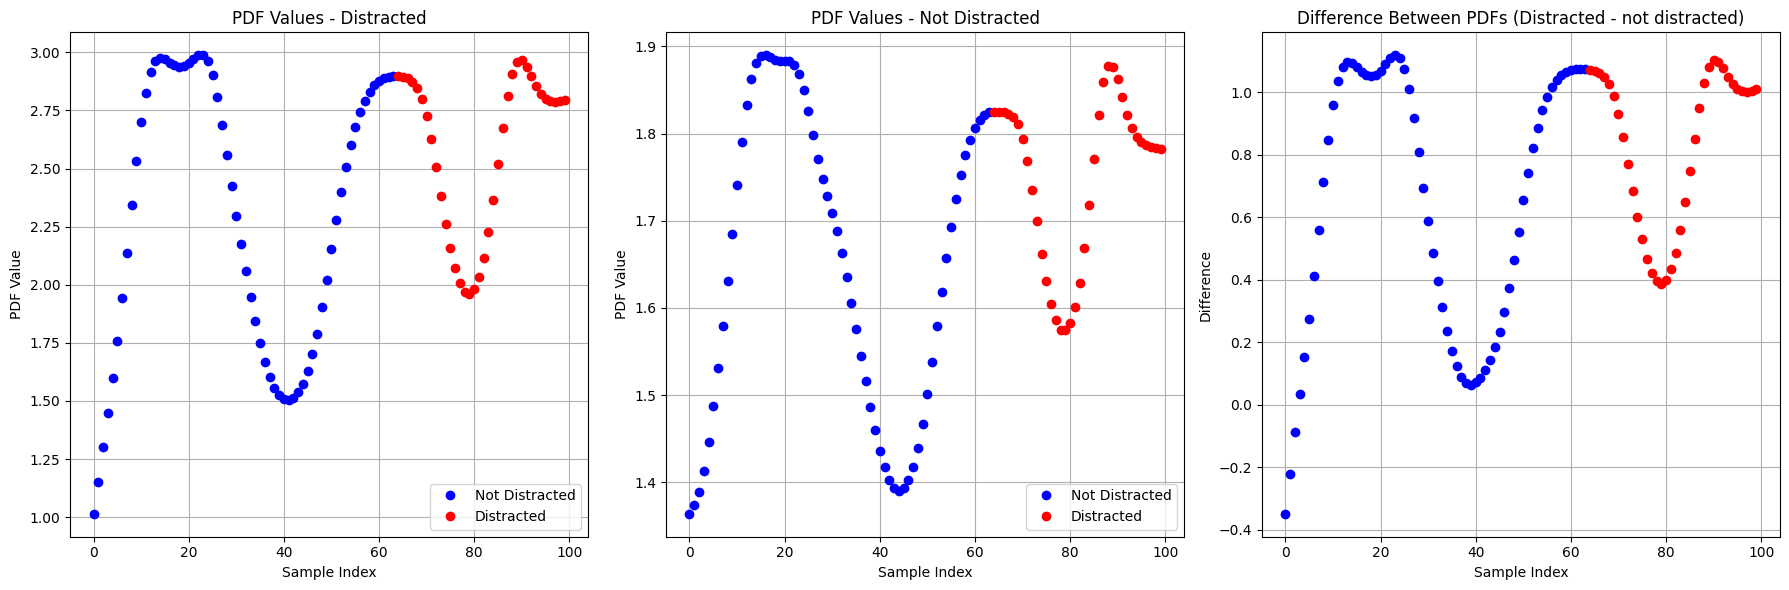

data_window.shape=(100, 2); tc_window.shape=(100,)


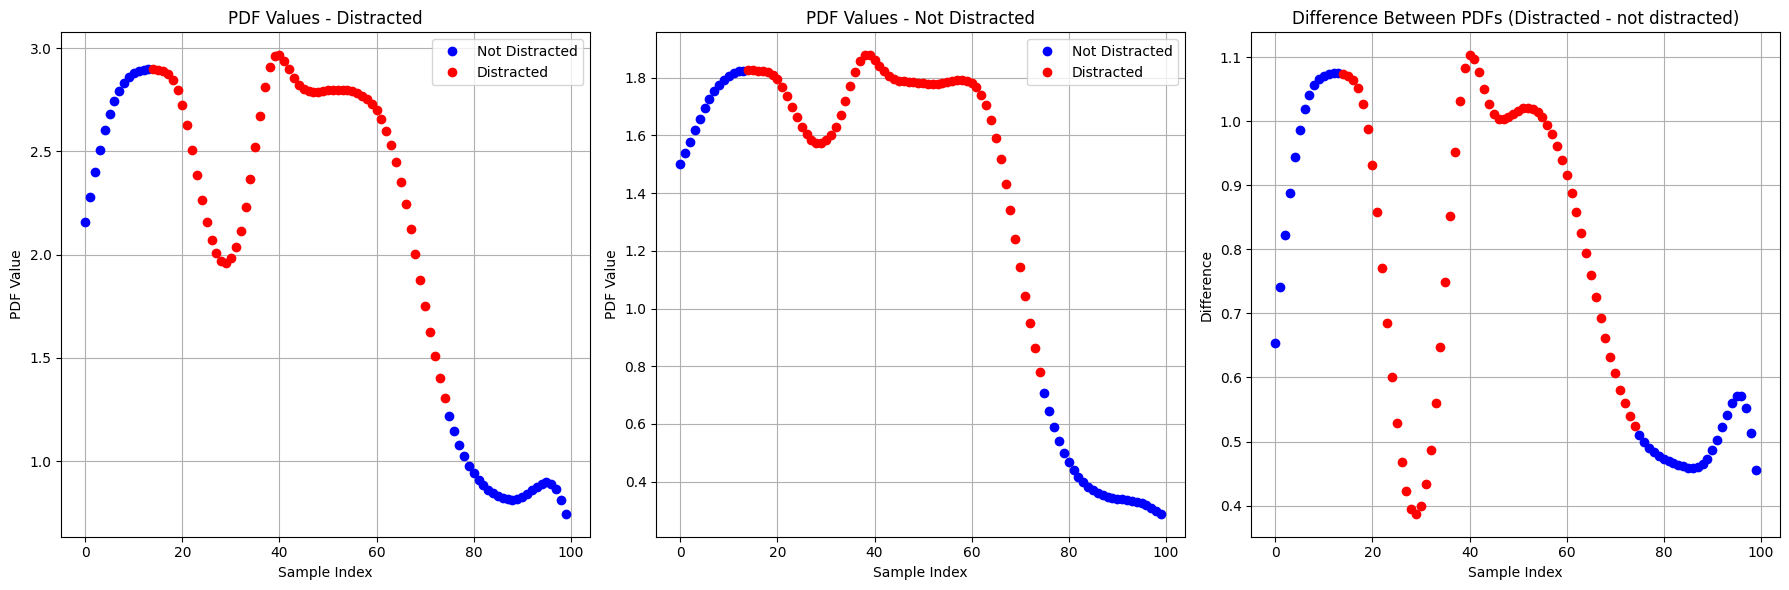

data_window.shape=(100, 2); tc_window.shape=(100,)


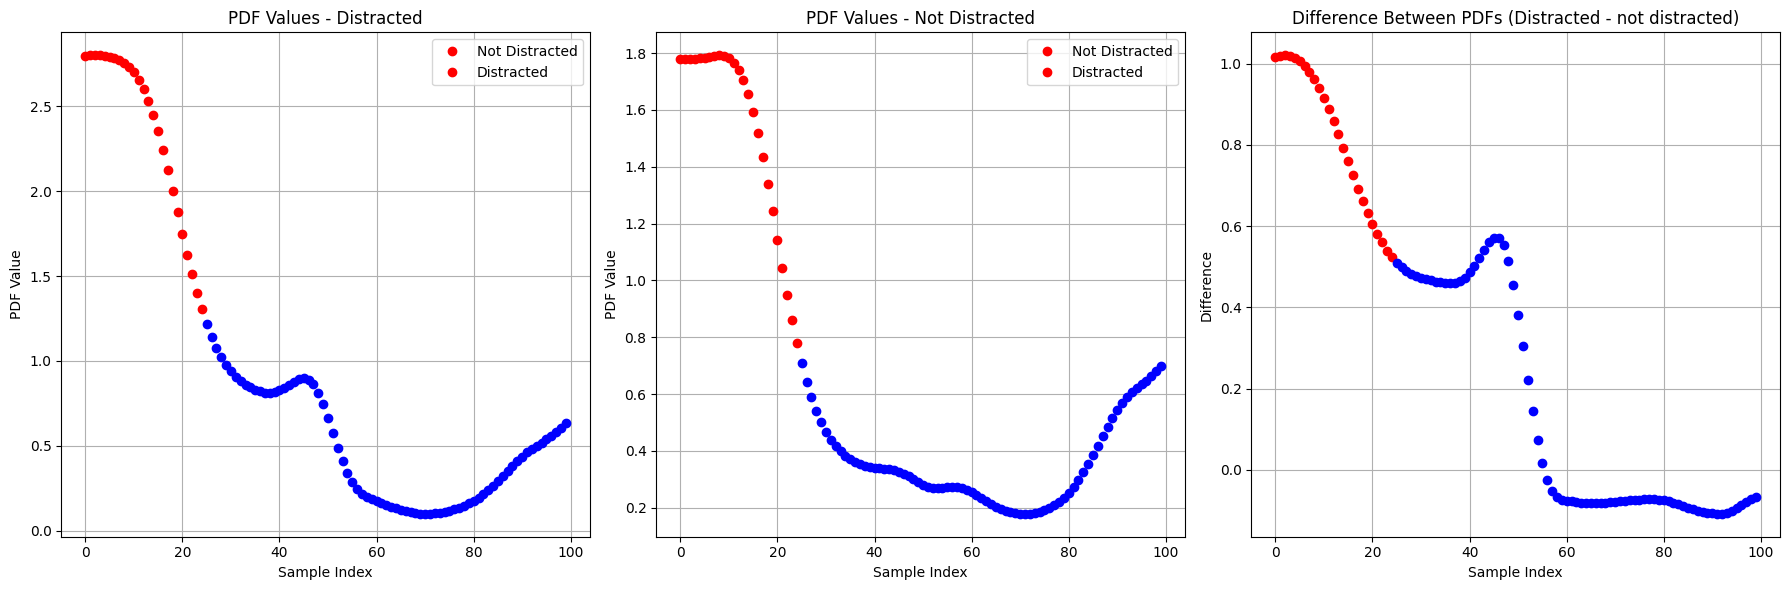

data_window.shape=(100, 2); tc_window.shape=(100,)


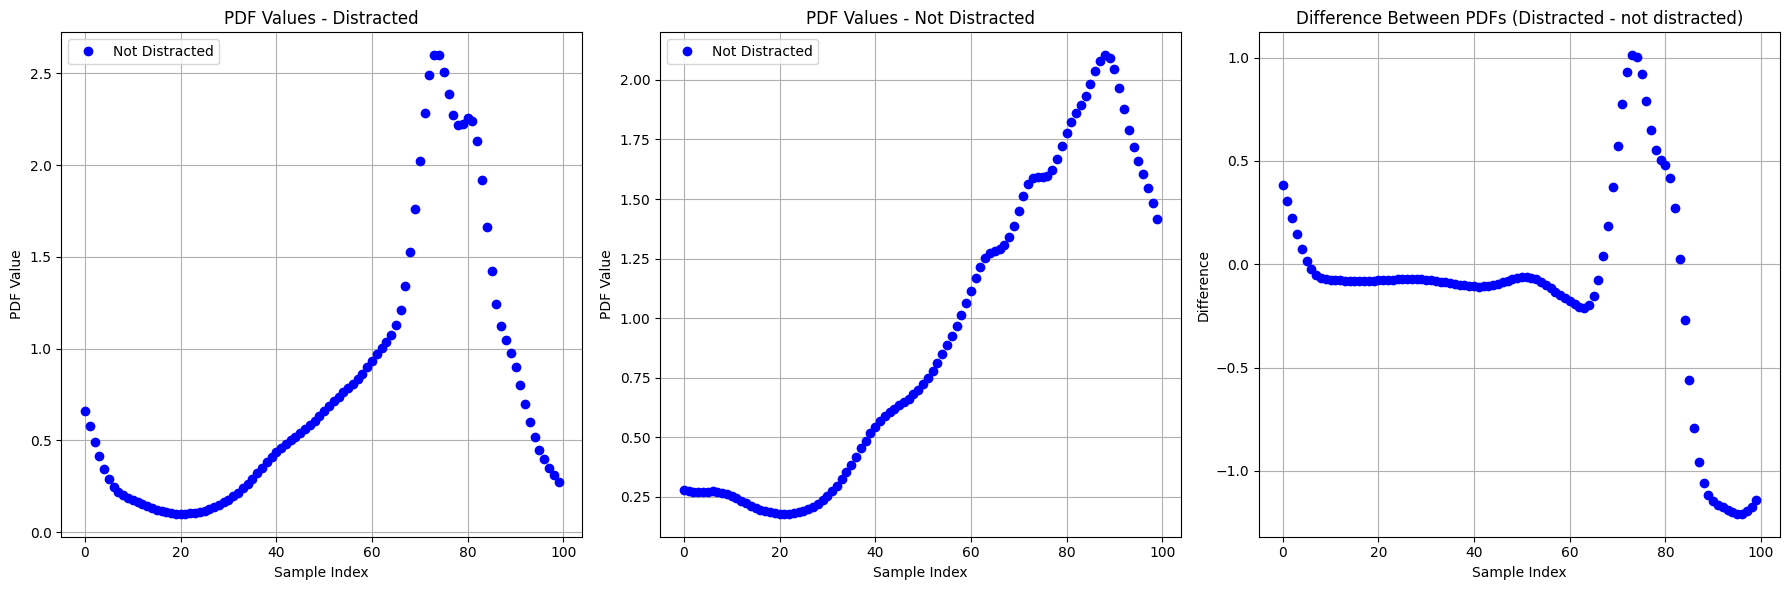

data_window.shape=(100, 2); tc_window.shape=(100,)


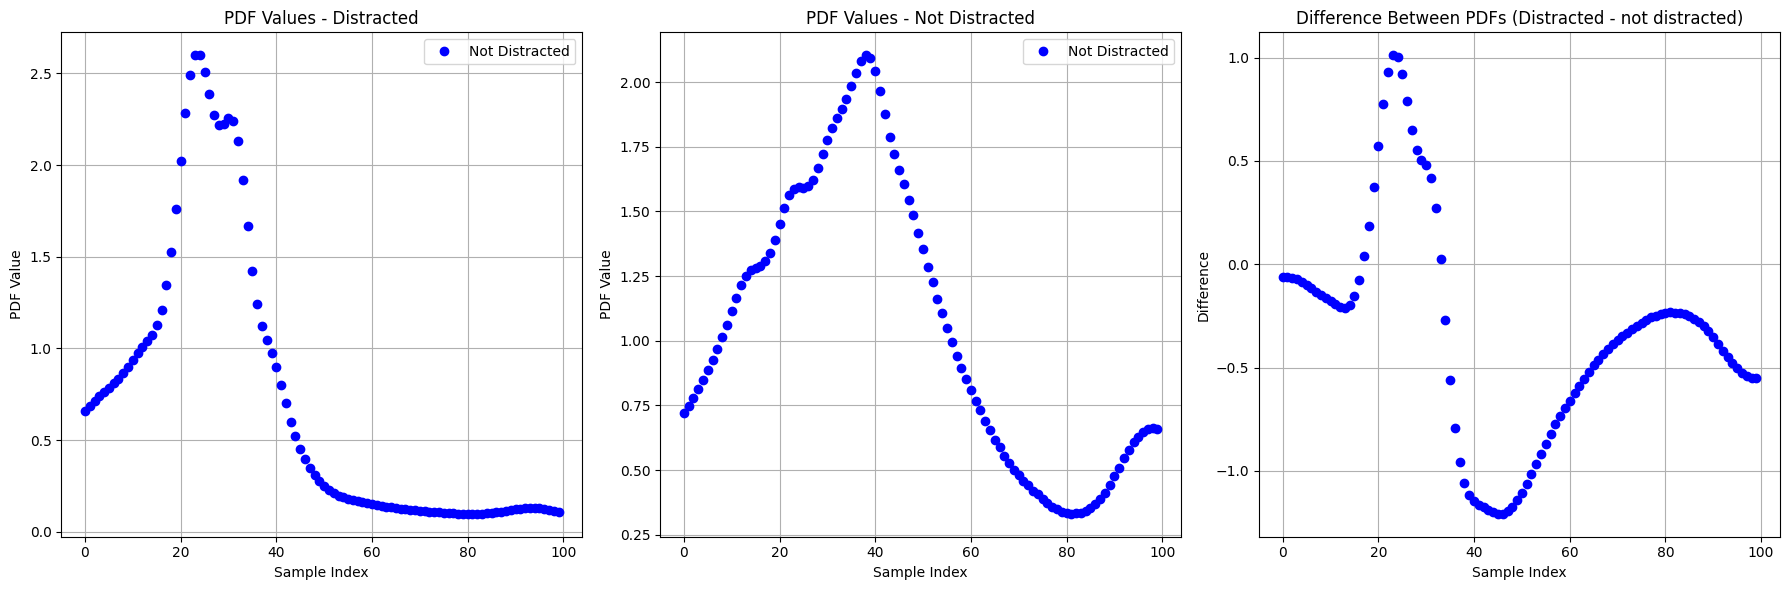

data_window.shape=(100, 2); tc_window.shape=(100,)


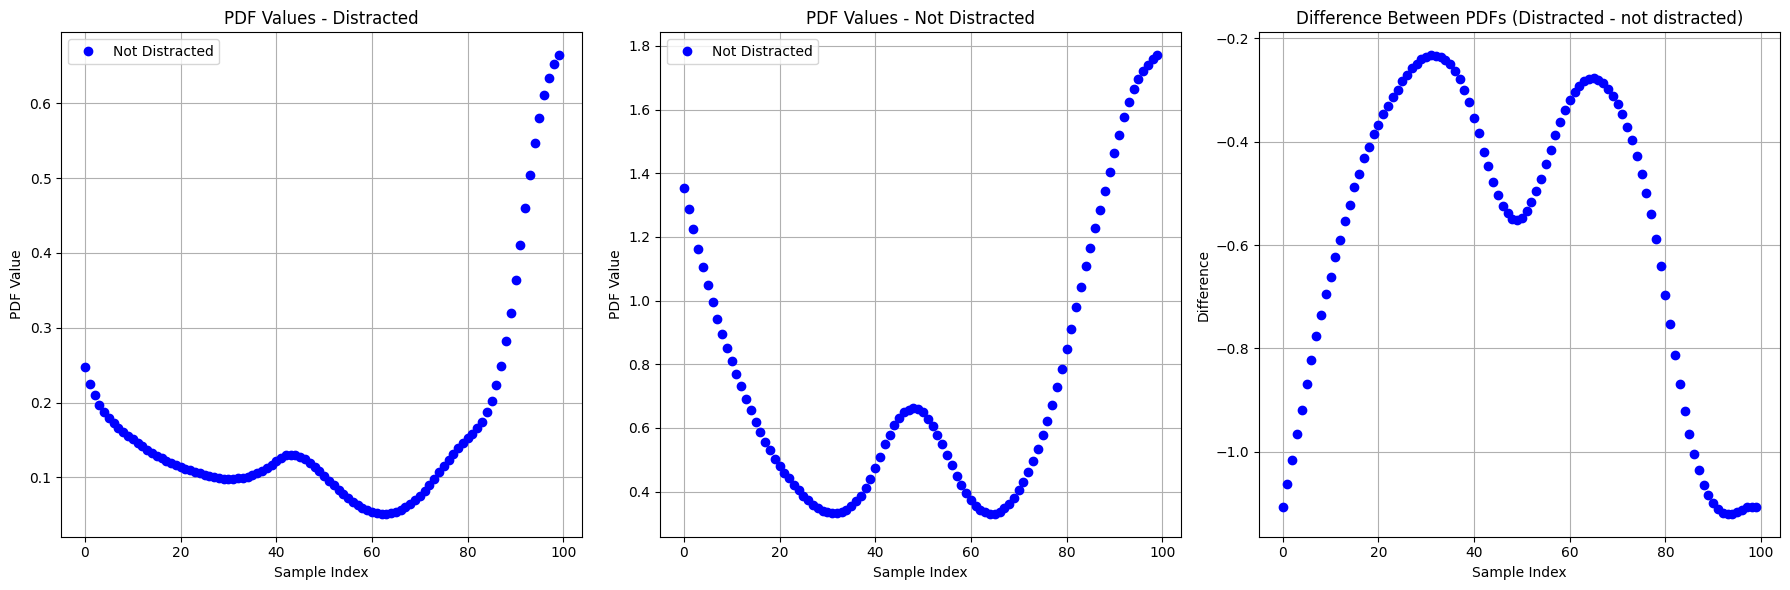

data_window.shape=(100, 2); tc_window.shape=(100,)


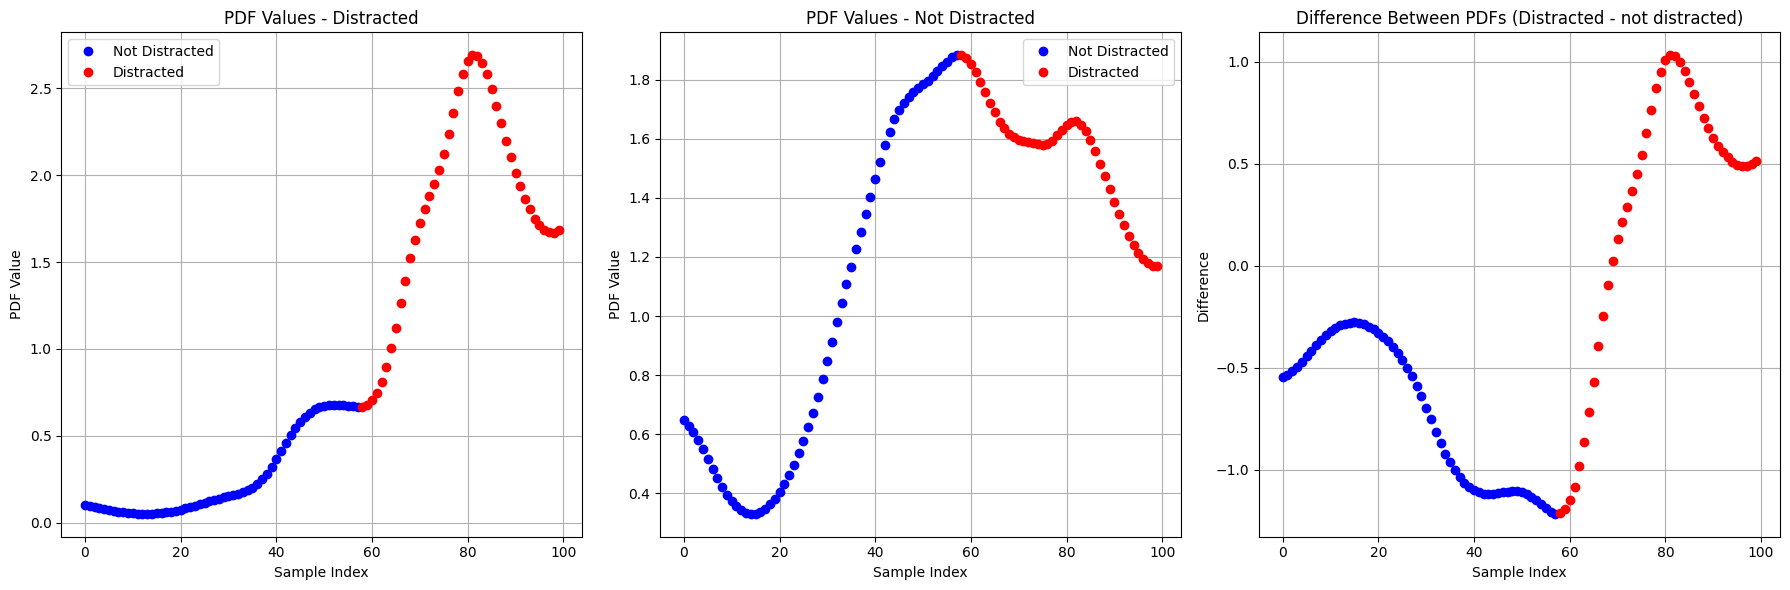

data_window.shape=(100, 2); tc_window.shape=(100,)


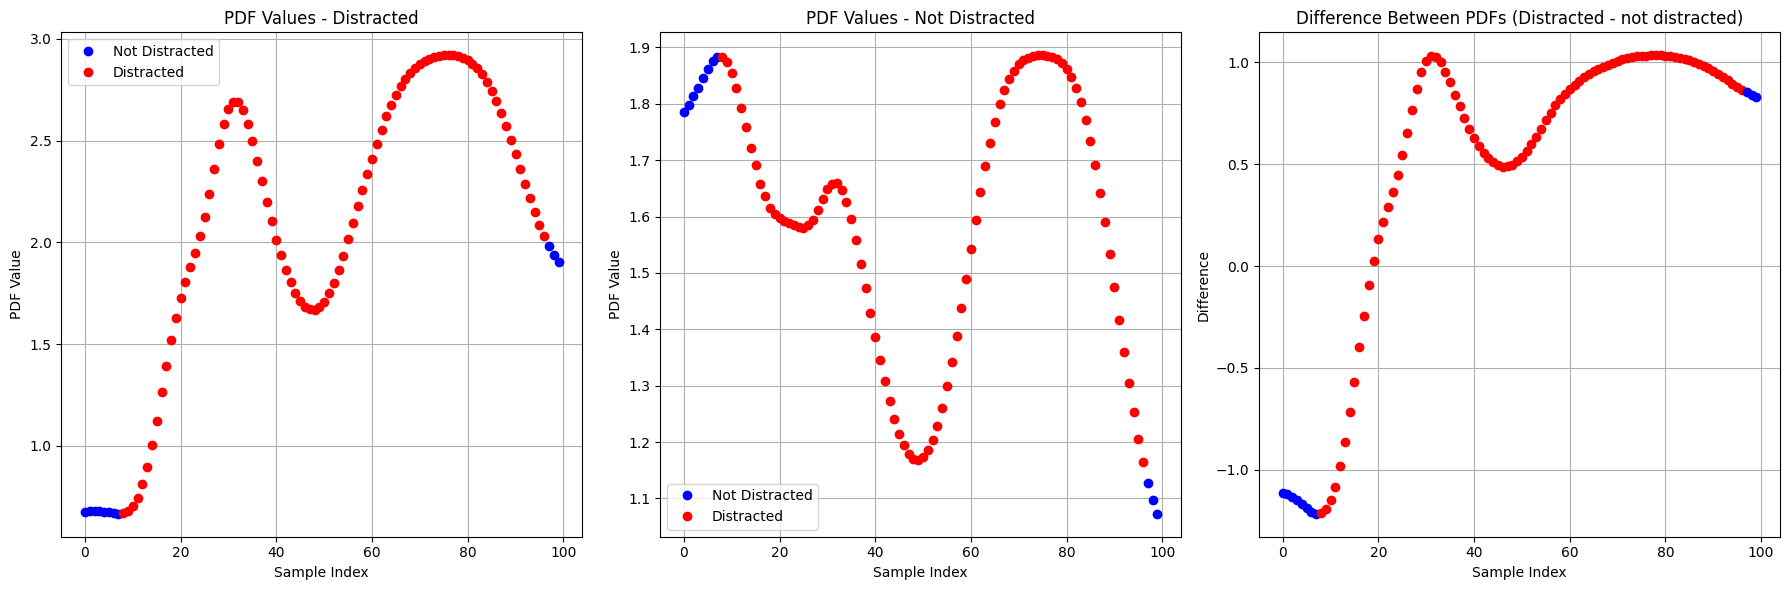

data_window.shape=(100, 2); tc_window.shape=(100,)


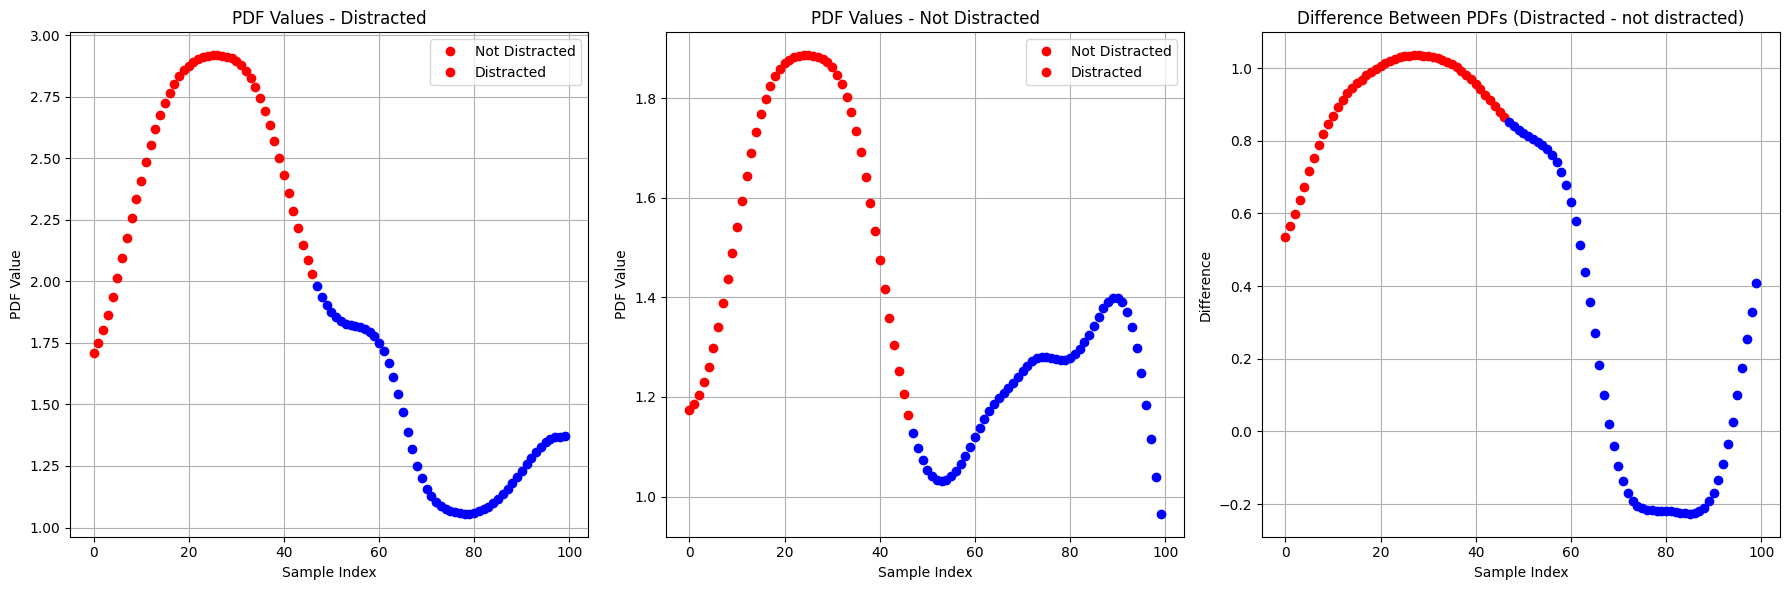

data_window.shape=(100, 2); tc_window.shape=(100,)


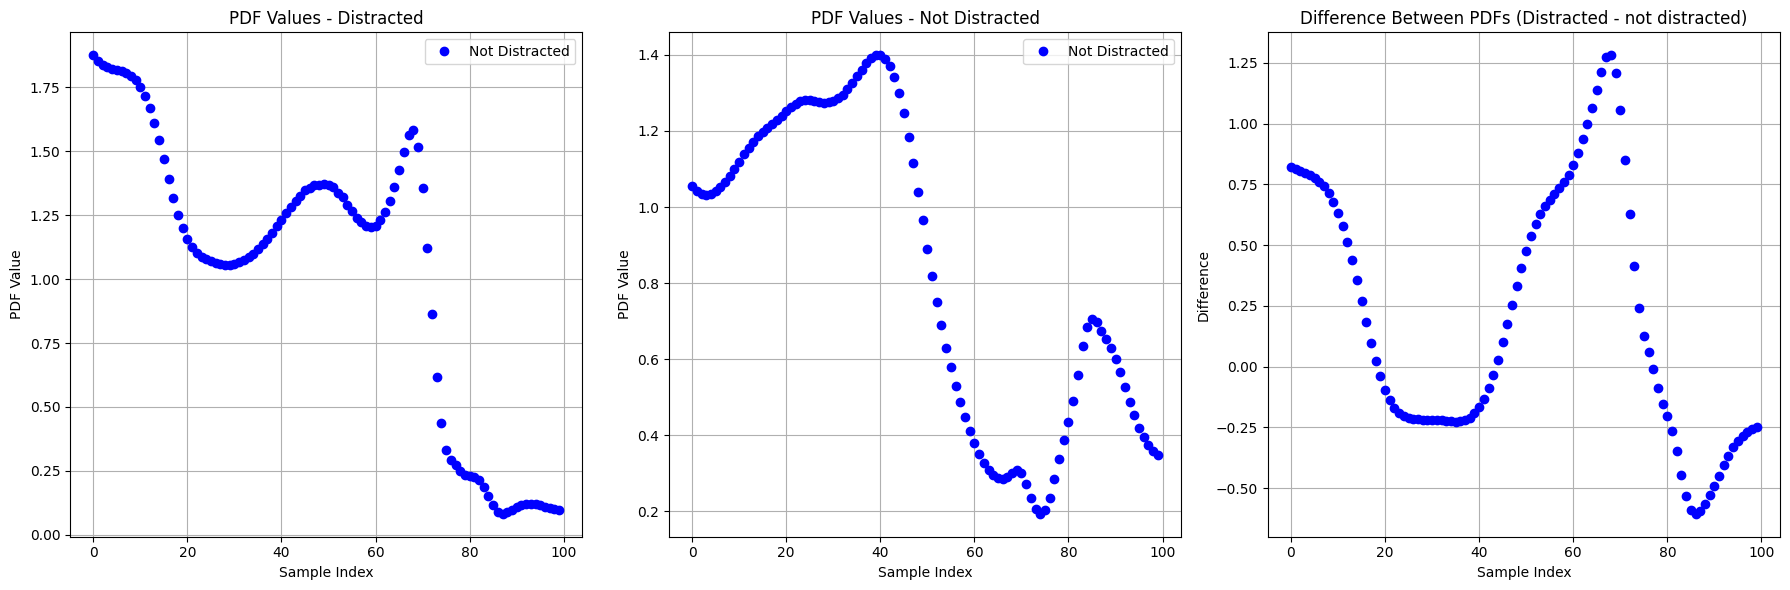

data_window.shape=(100, 2); tc_window.shape=(100,)


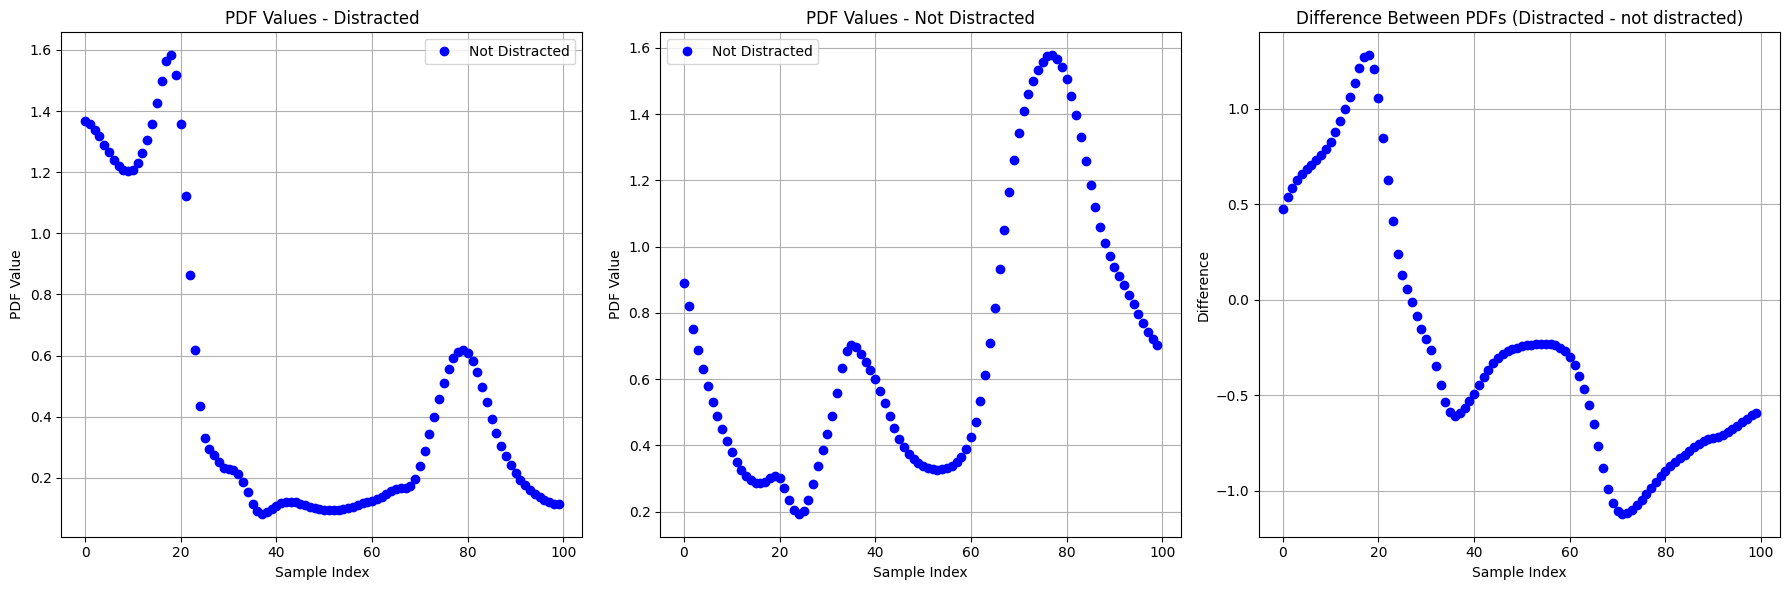

data_window.shape=(100, 2); tc_window.shape=(100,)


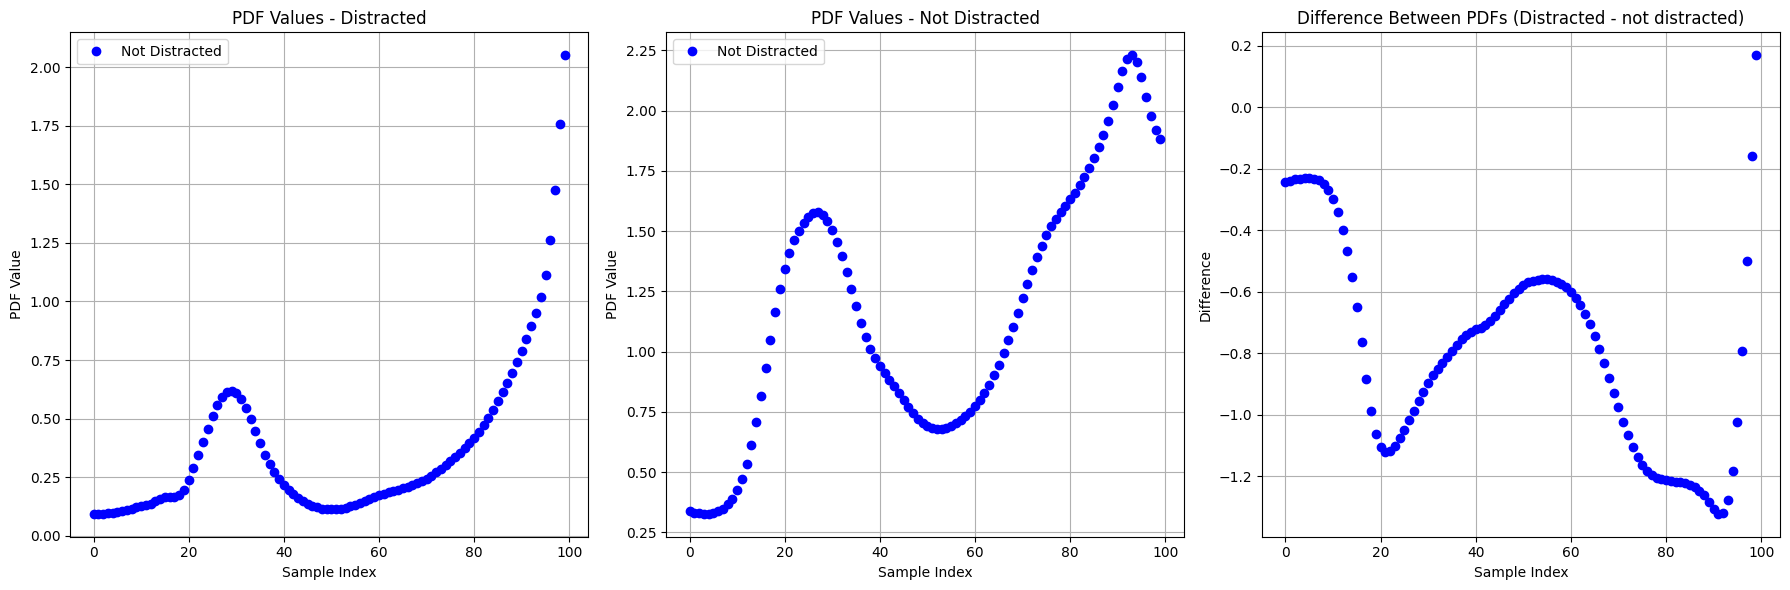

data_window.shape=(100, 2); tc_window.shape=(100,)


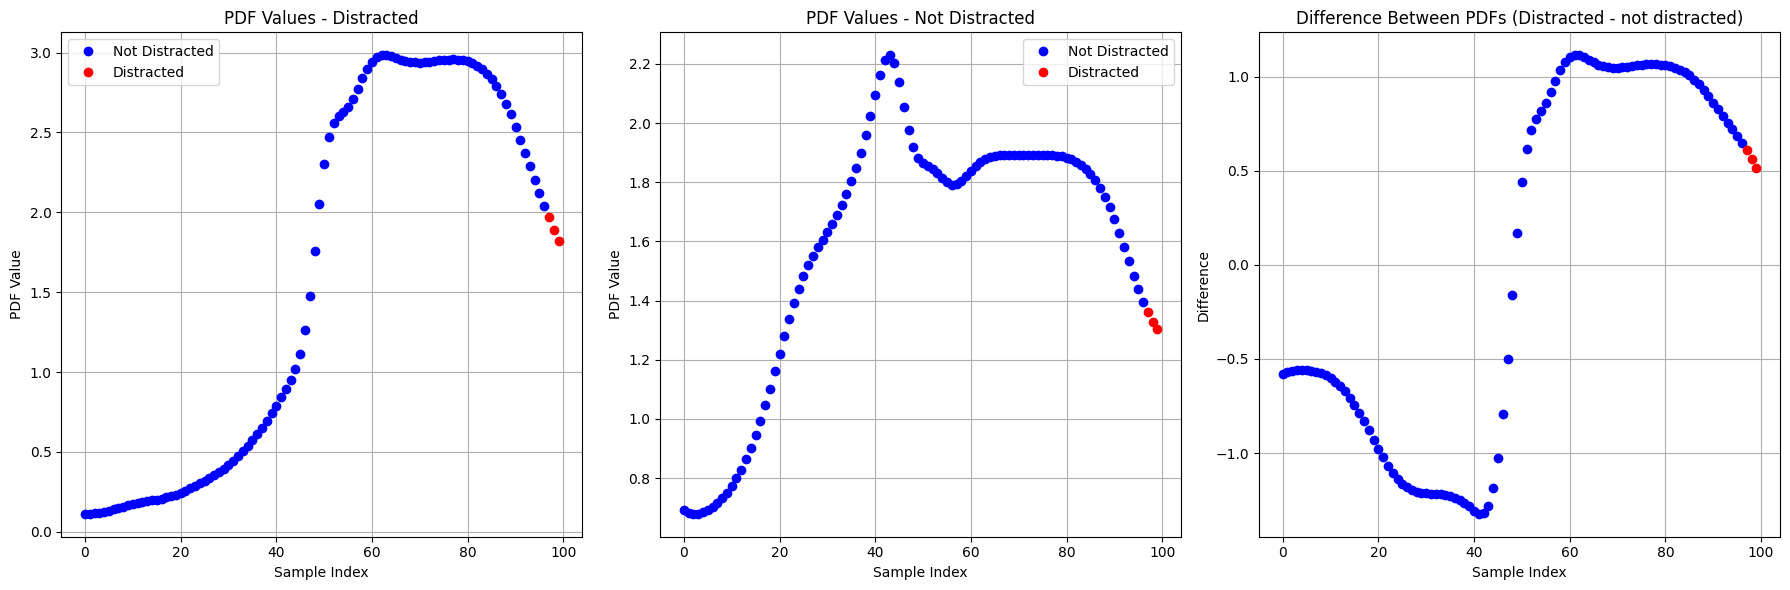

data_window.shape=(100, 2); tc_window.shape=(100,)


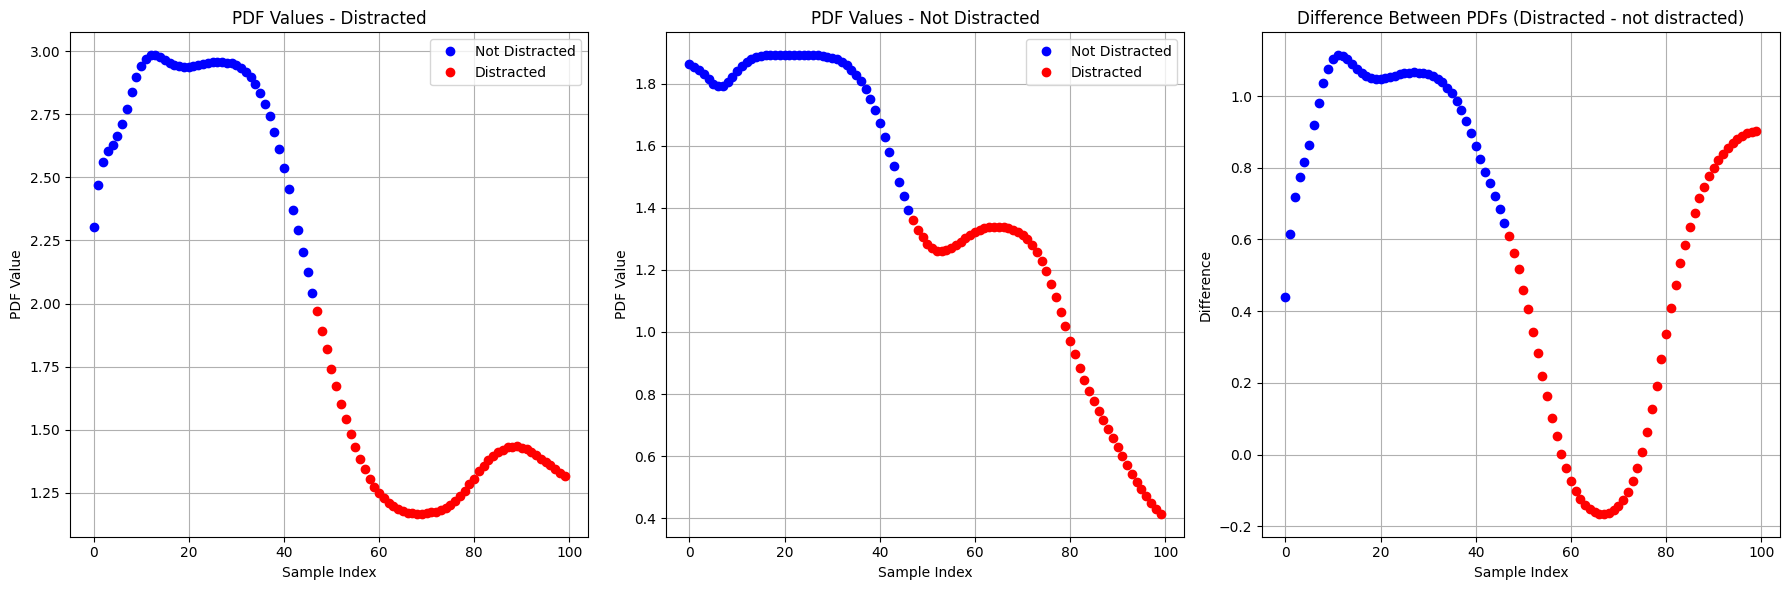

data_window.shape=(100, 2); tc_window.shape=(100,)


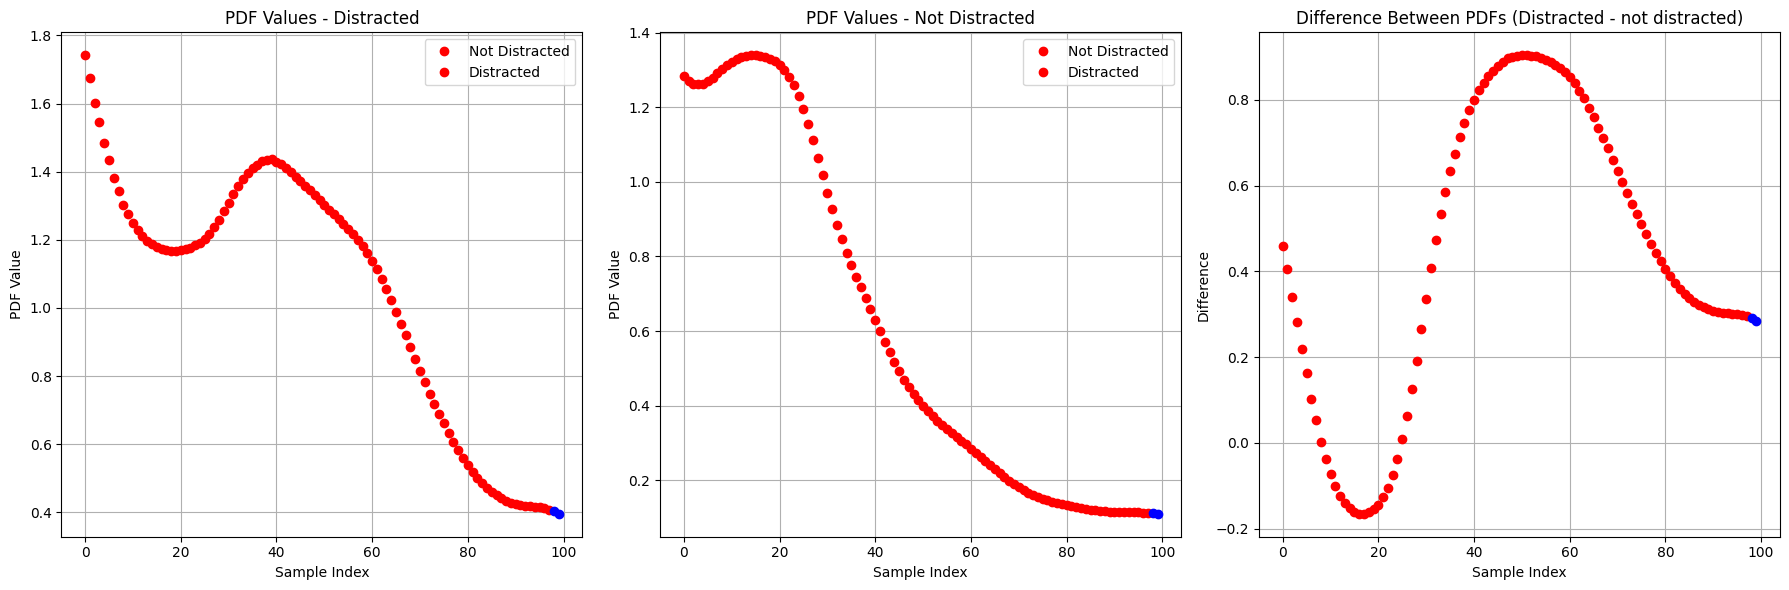

data_window.shape=(100, 2); tc_window.shape=(100,)


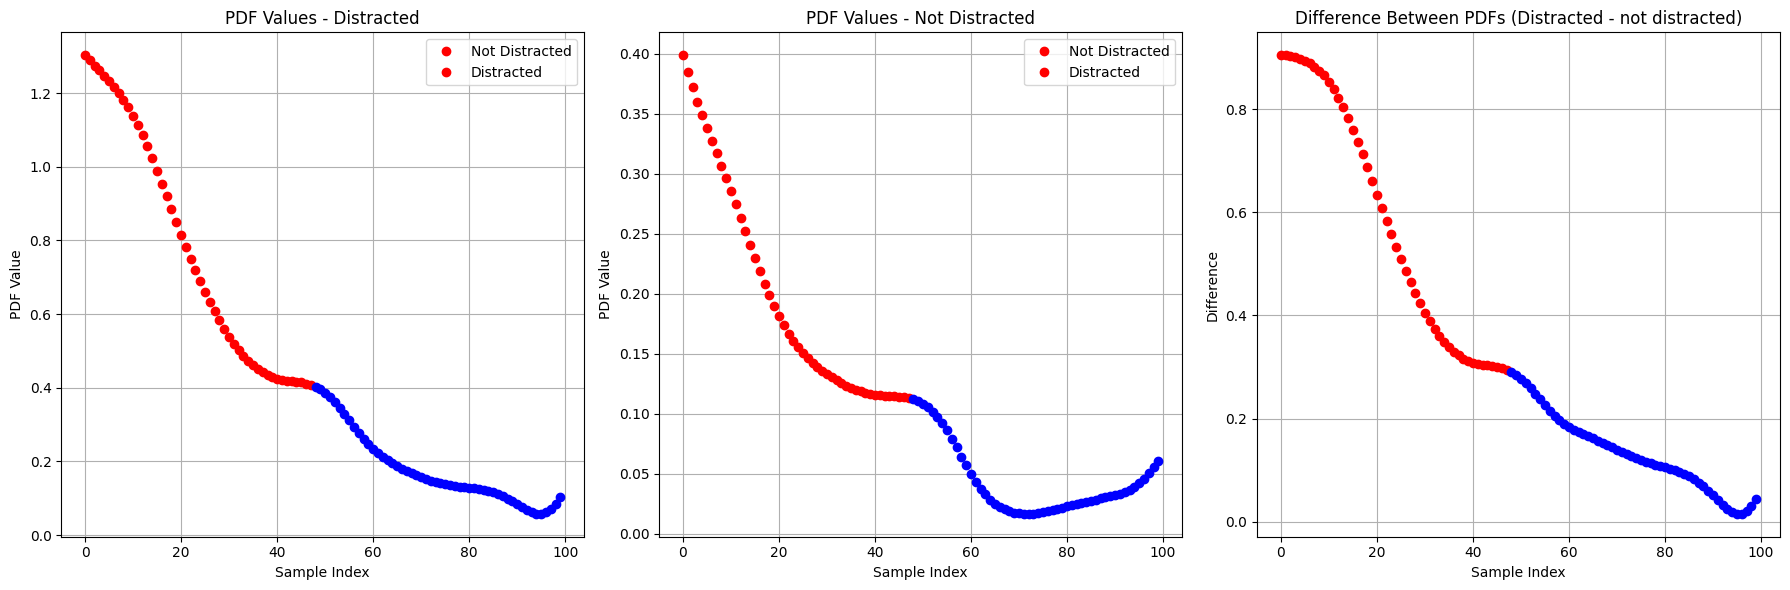

data_window.shape=(100, 2); tc_window.shape=(100,)


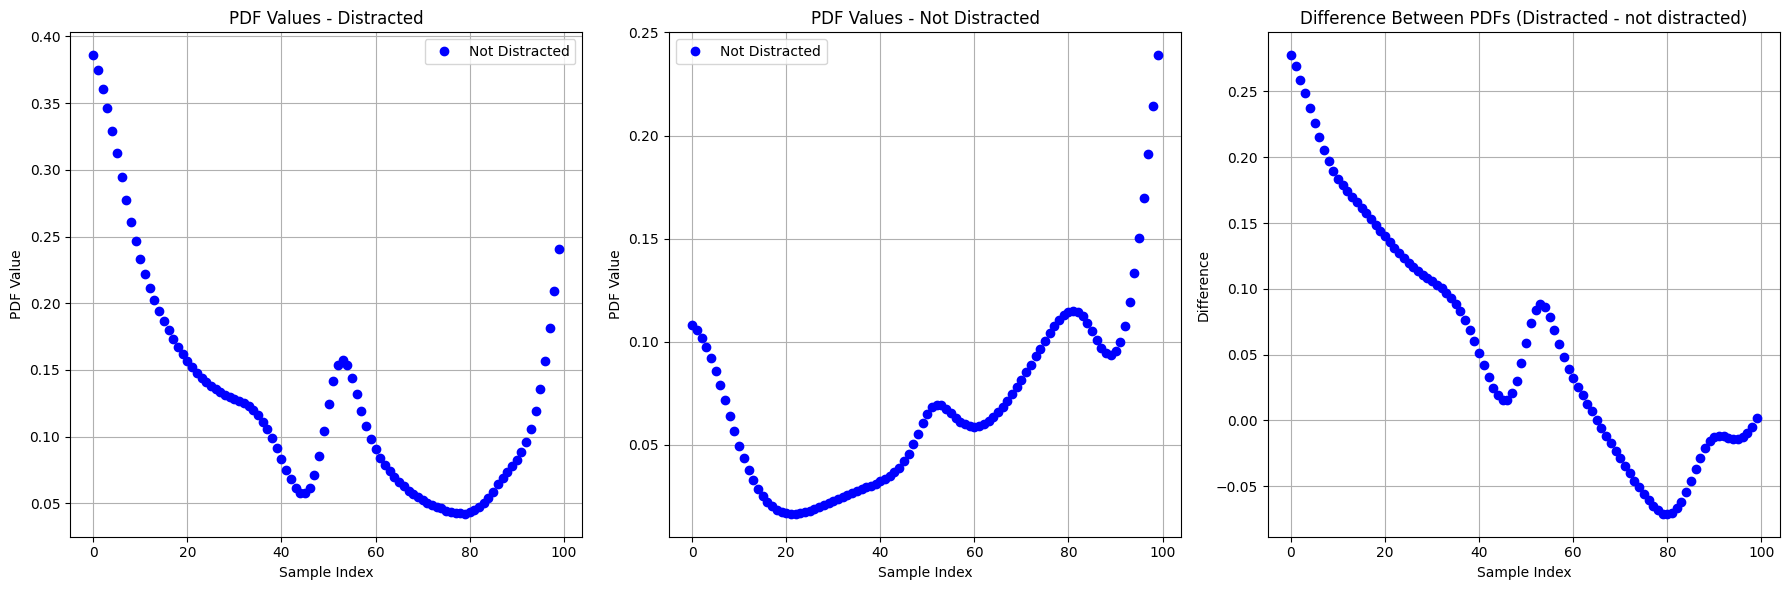

data_window.shape=(100, 2); tc_window.shape=(100,)


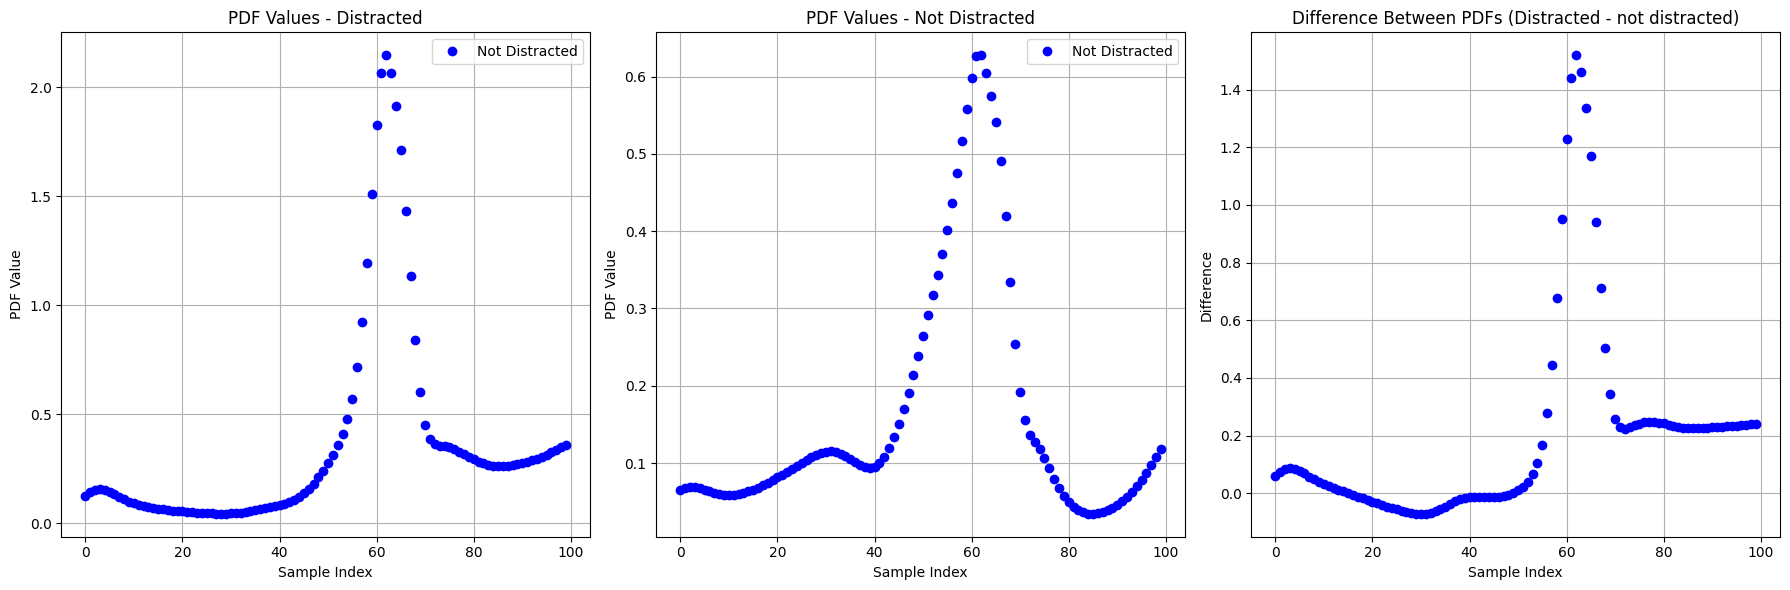

data_window.shape=(100, 2); tc_window.shape=(100,)


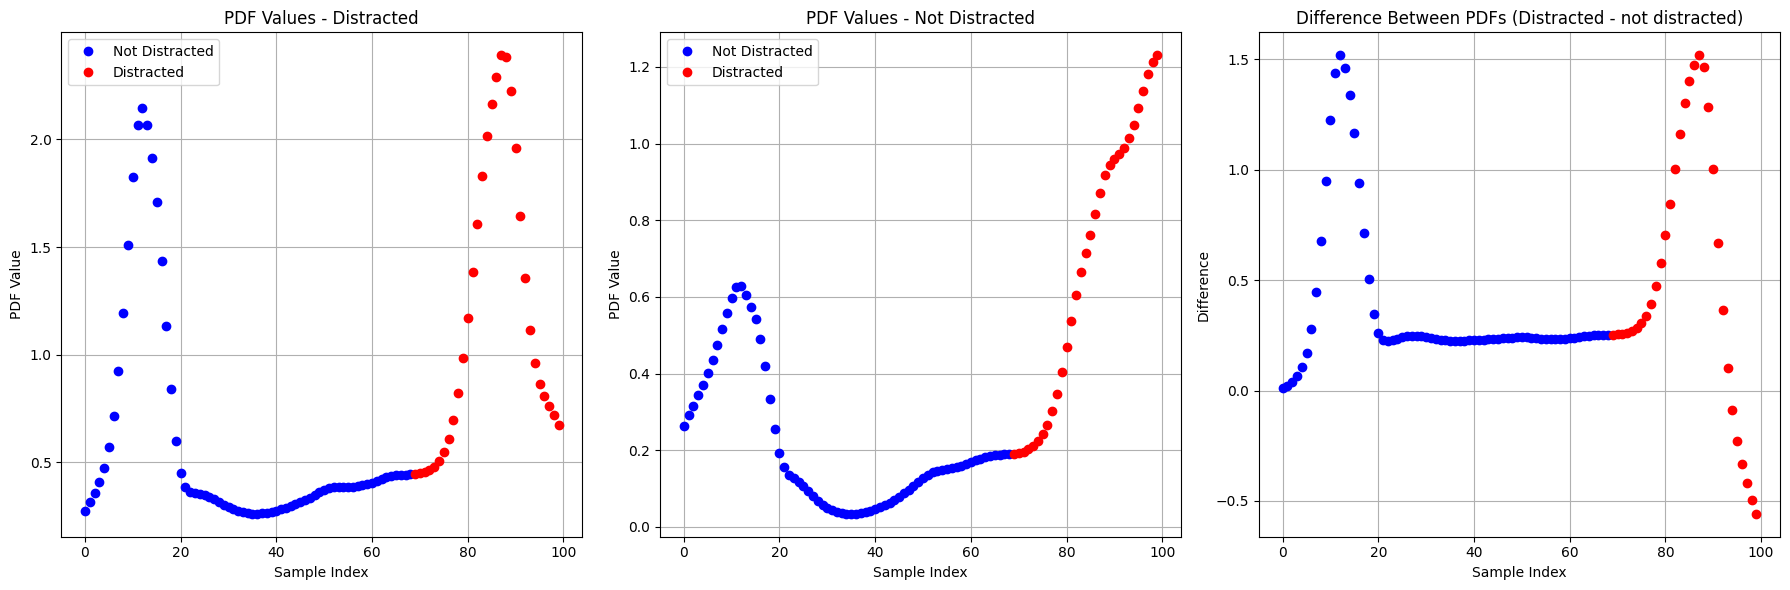

data_window.shape=(100, 2); tc_window.shape=(100,)


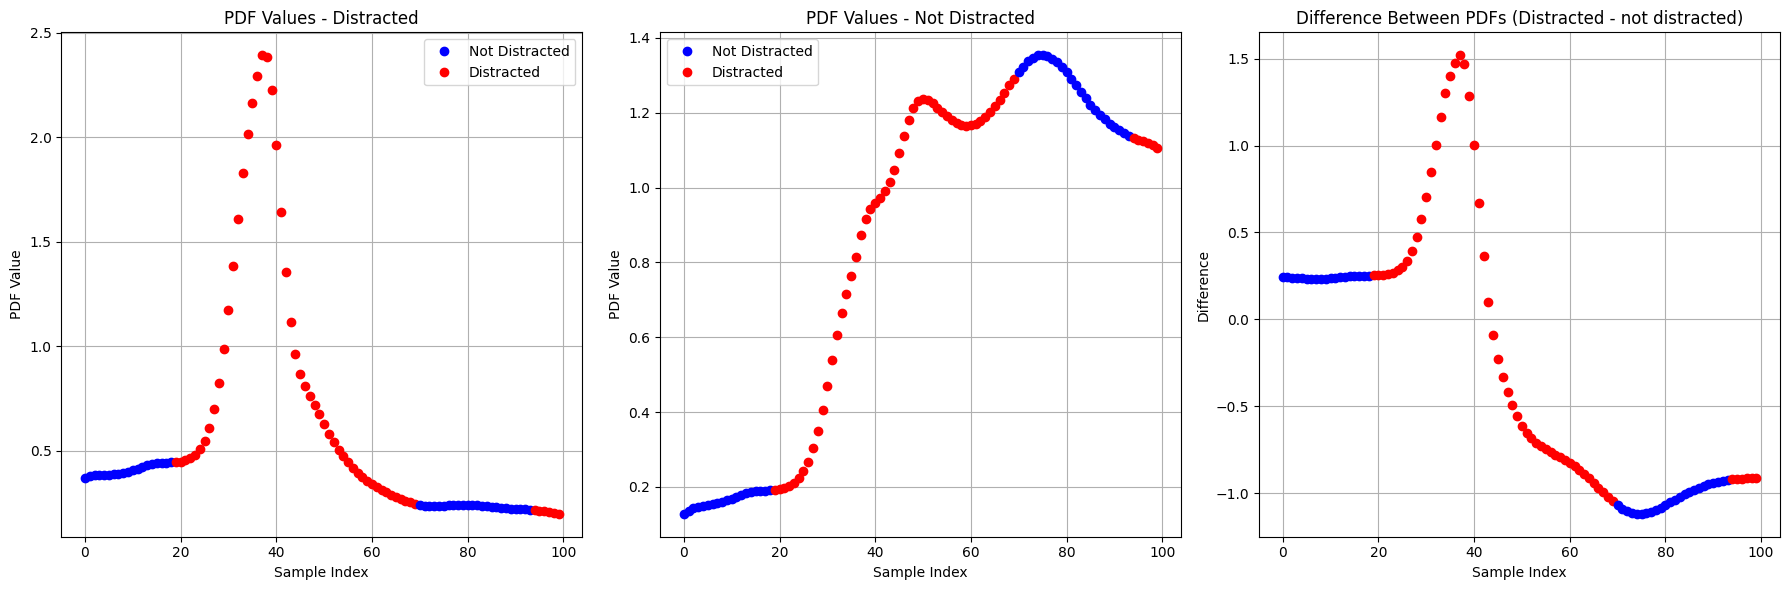

data_window.shape=(100, 2); tc_window.shape=(100,)


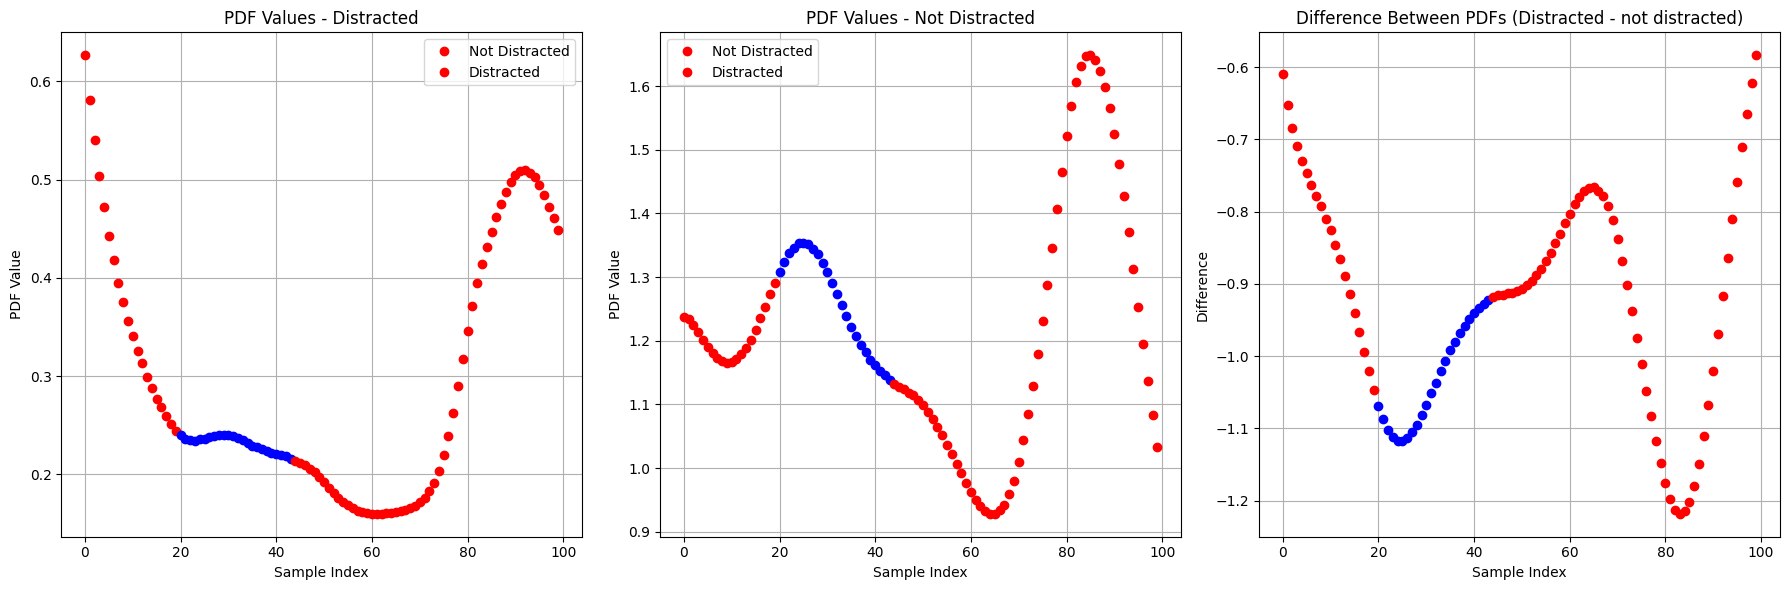

data_window.shape=(100, 2); tc_window.shape=(100,)


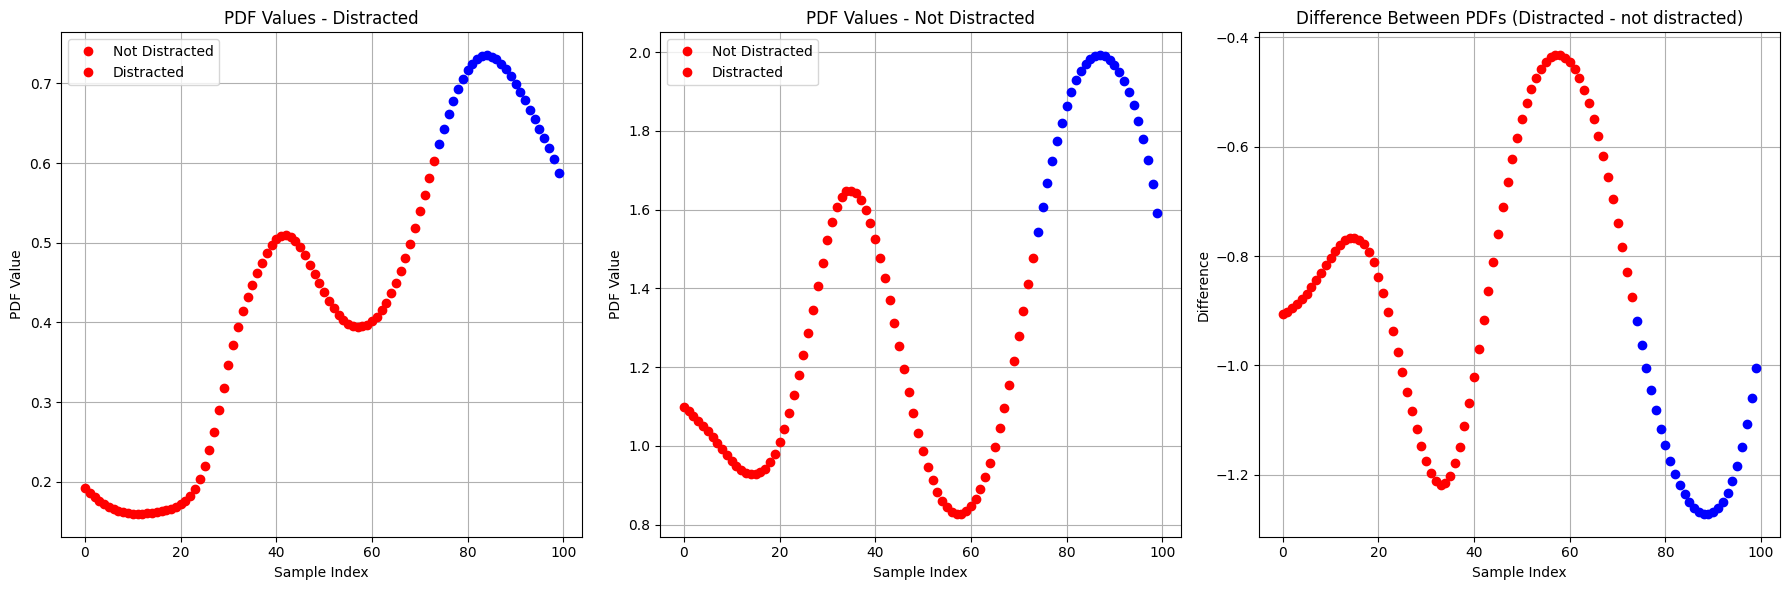

data_window.shape=(100, 2); tc_window.shape=(100,)


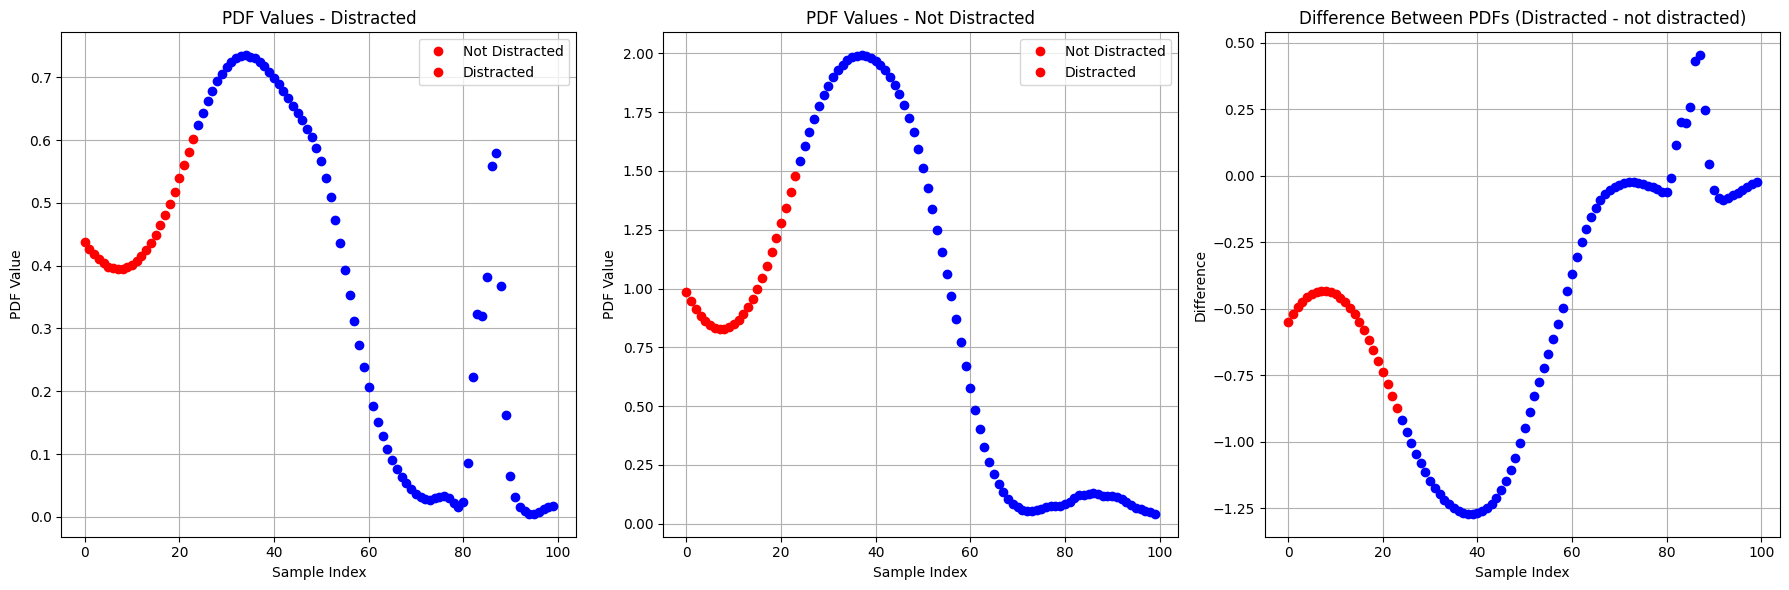

data_window.shape=(100, 2); tc_window.shape=(100,)


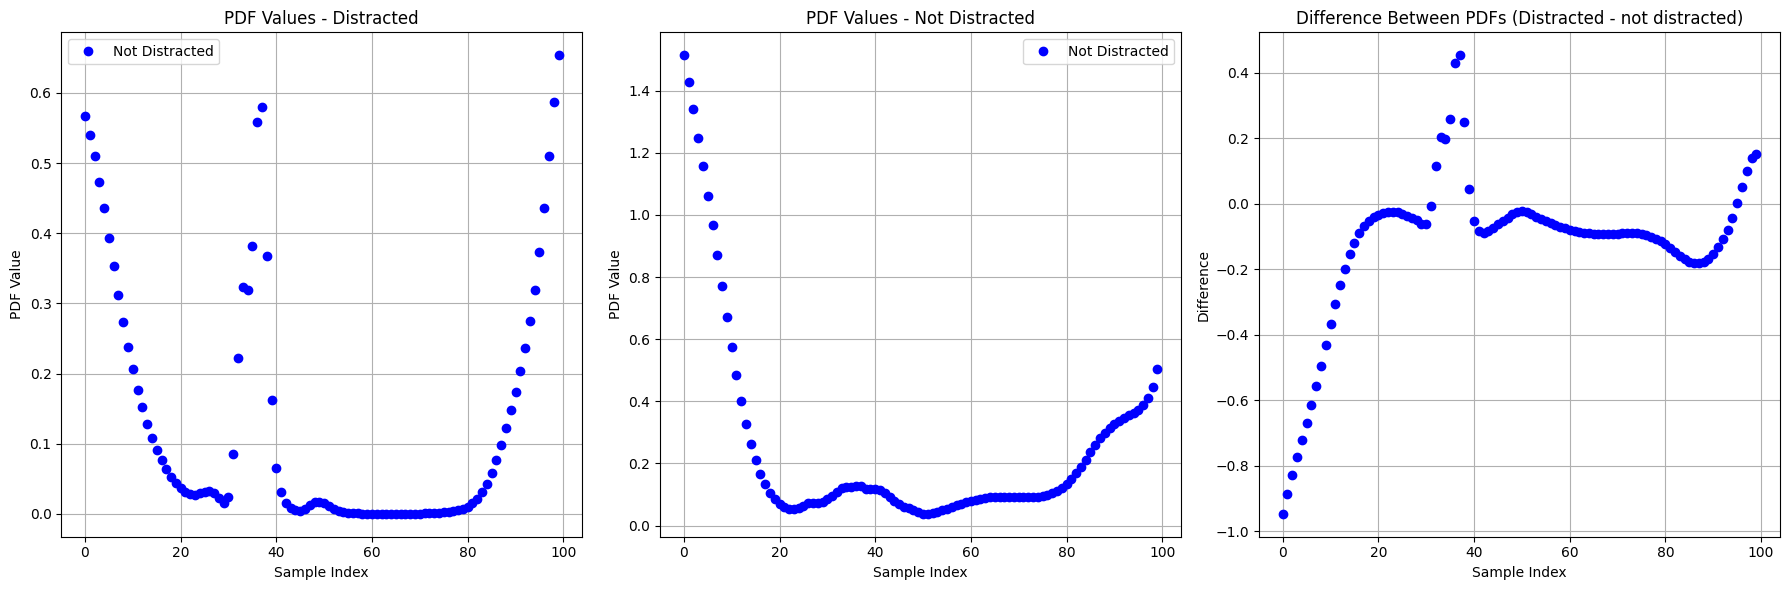

data_window.shape=(100, 2); tc_window.shape=(100,)


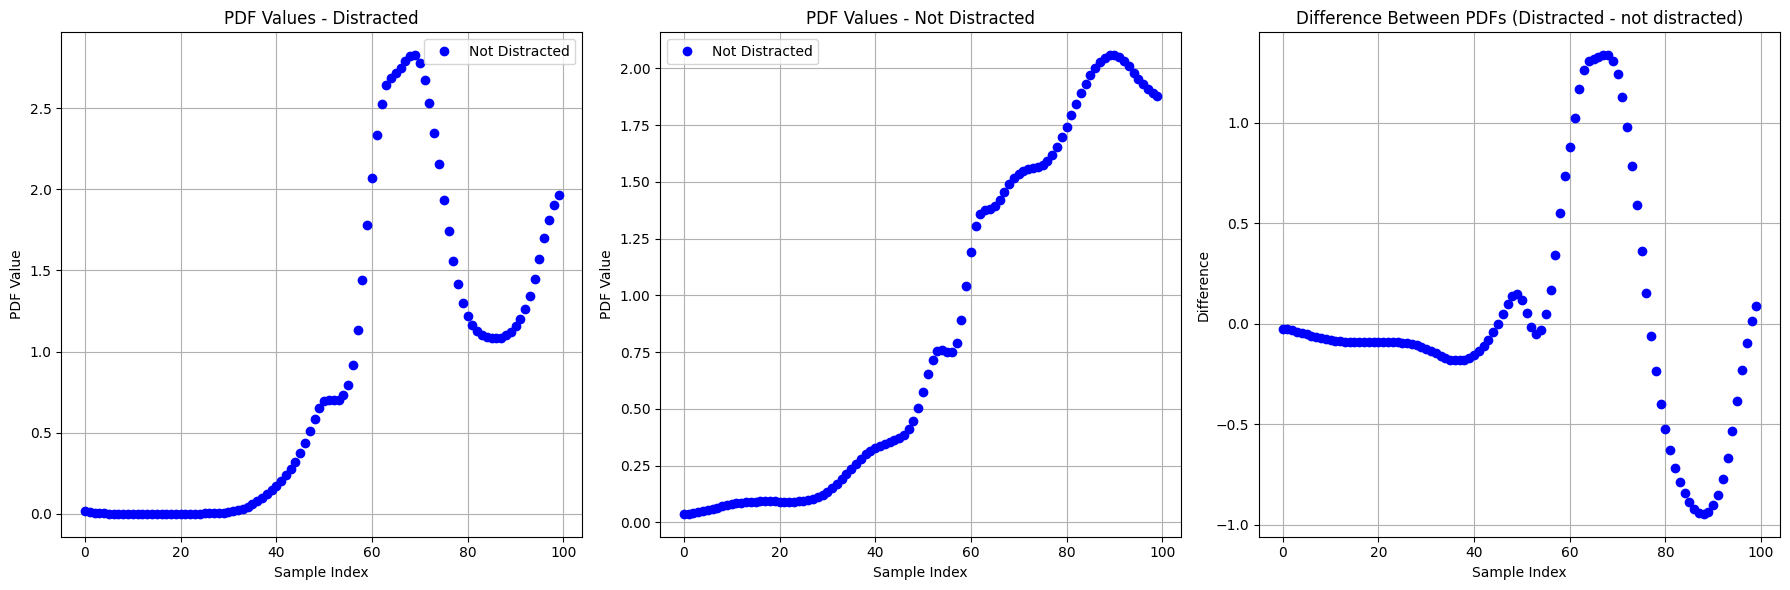

data_window.shape=(100, 2); tc_window.shape=(100,)


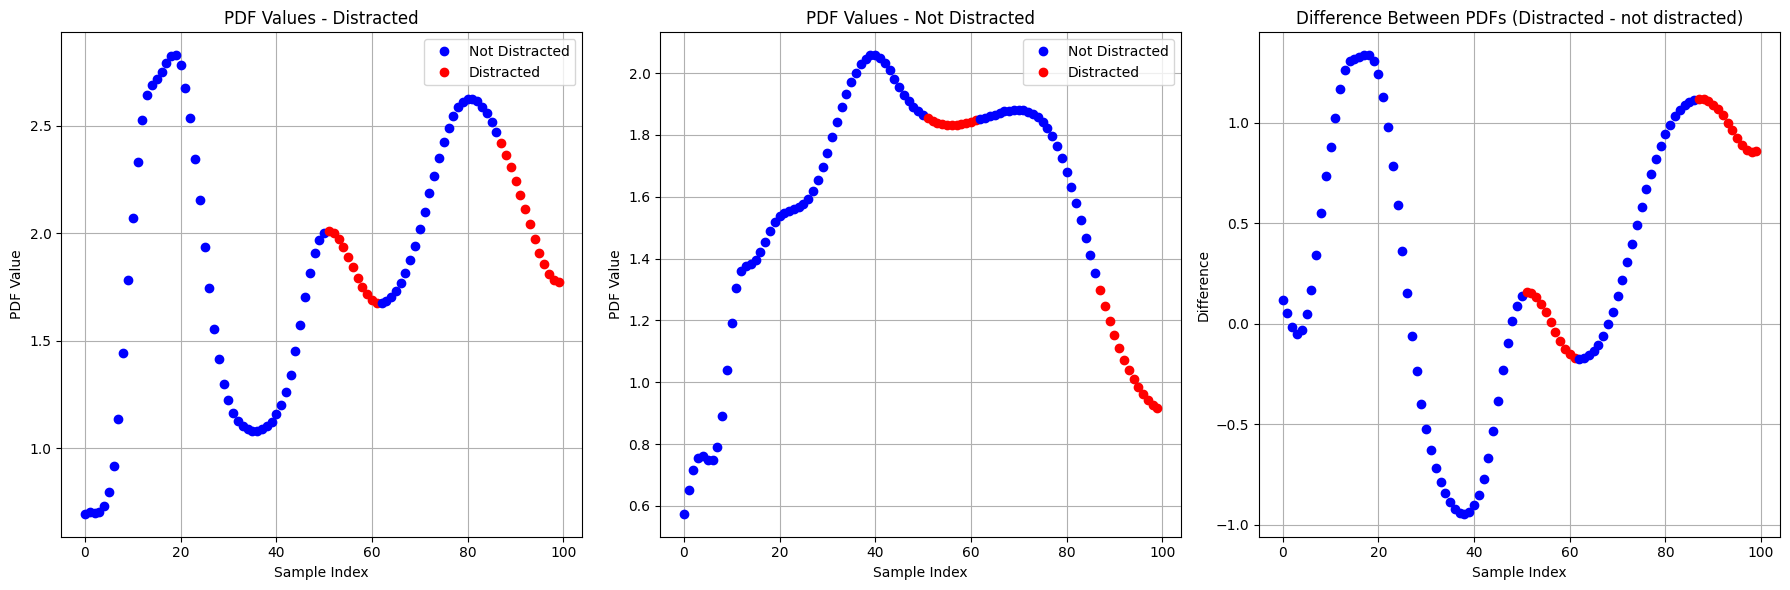

data_window.shape=(100, 2); tc_window.shape=(100,)


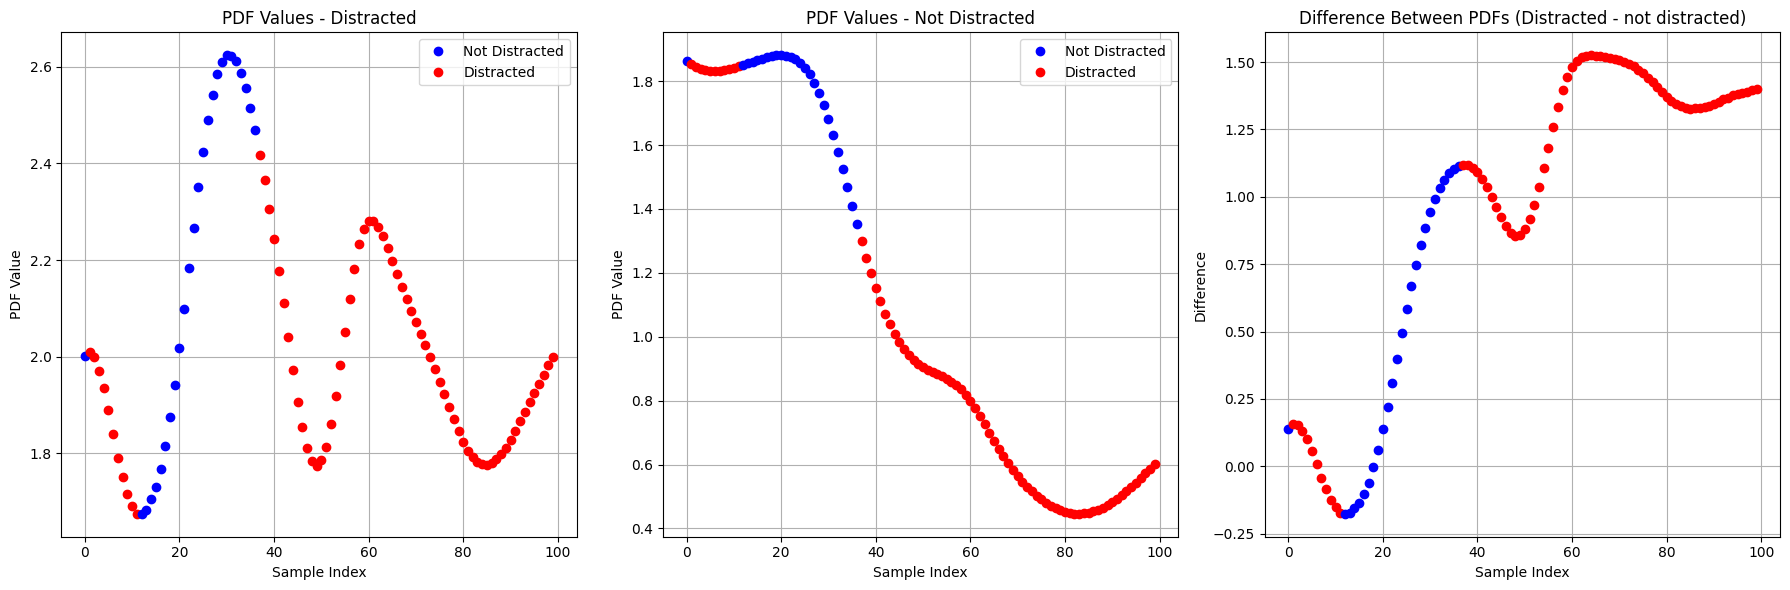

data_window.shape=(100, 2); tc_window.shape=(100,)


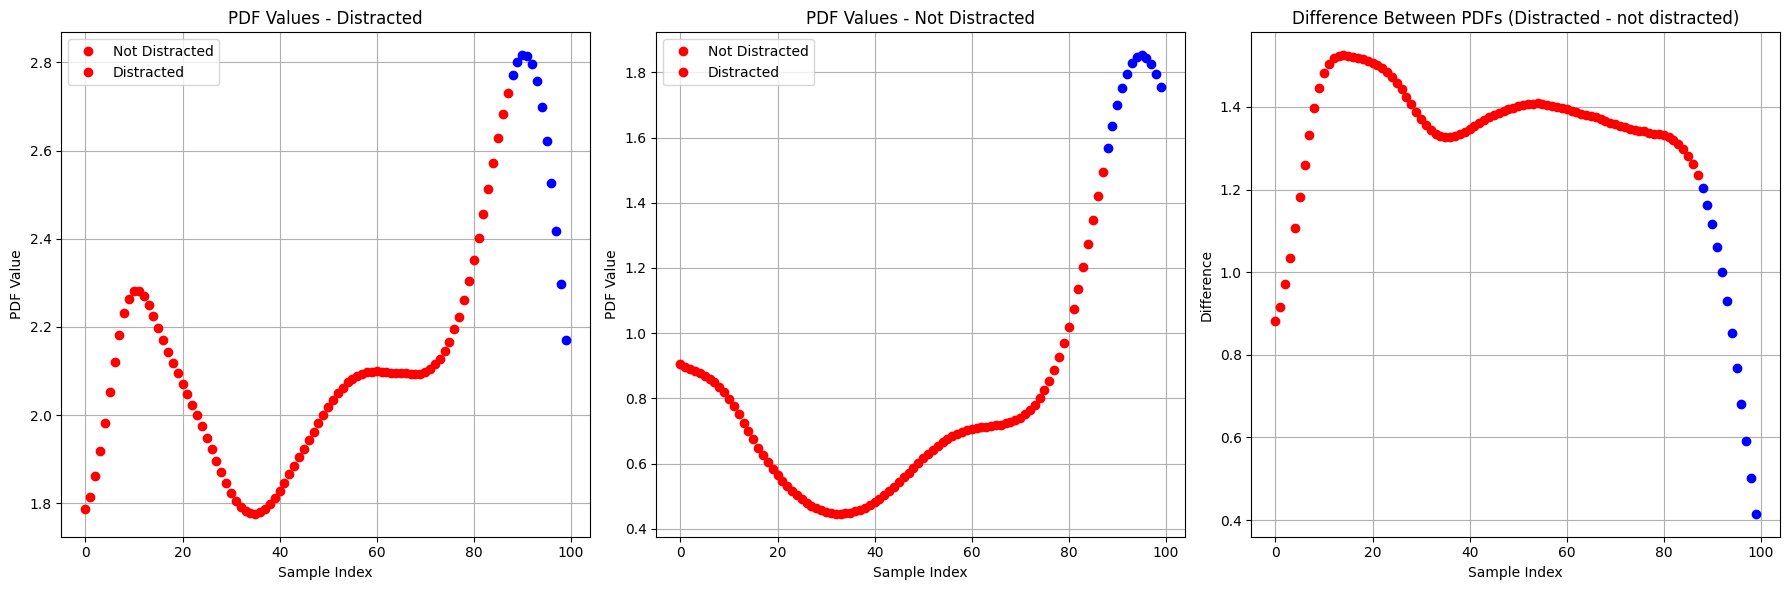

data_window.shape=(100, 2); tc_window.shape=(100,)


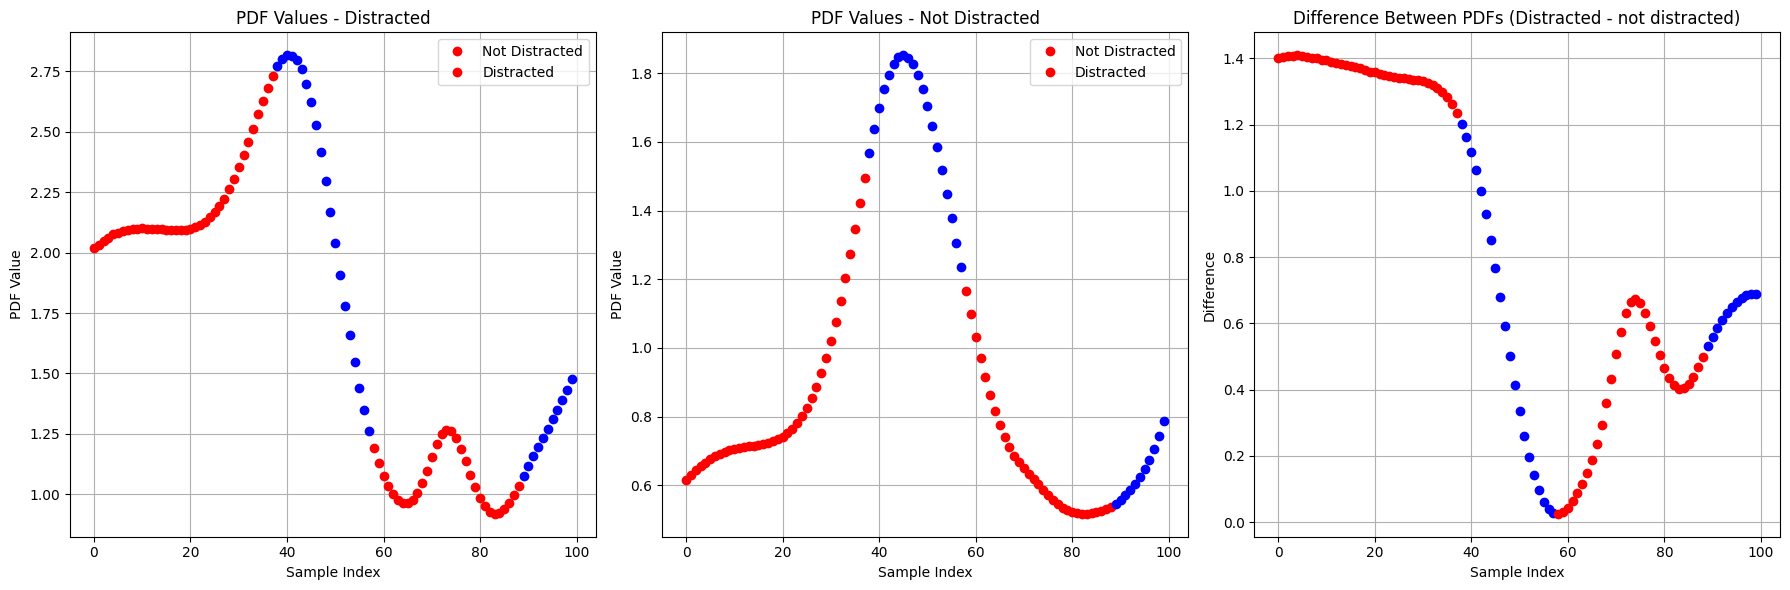

data_window.shape=(100, 2); tc_window.shape=(100,)


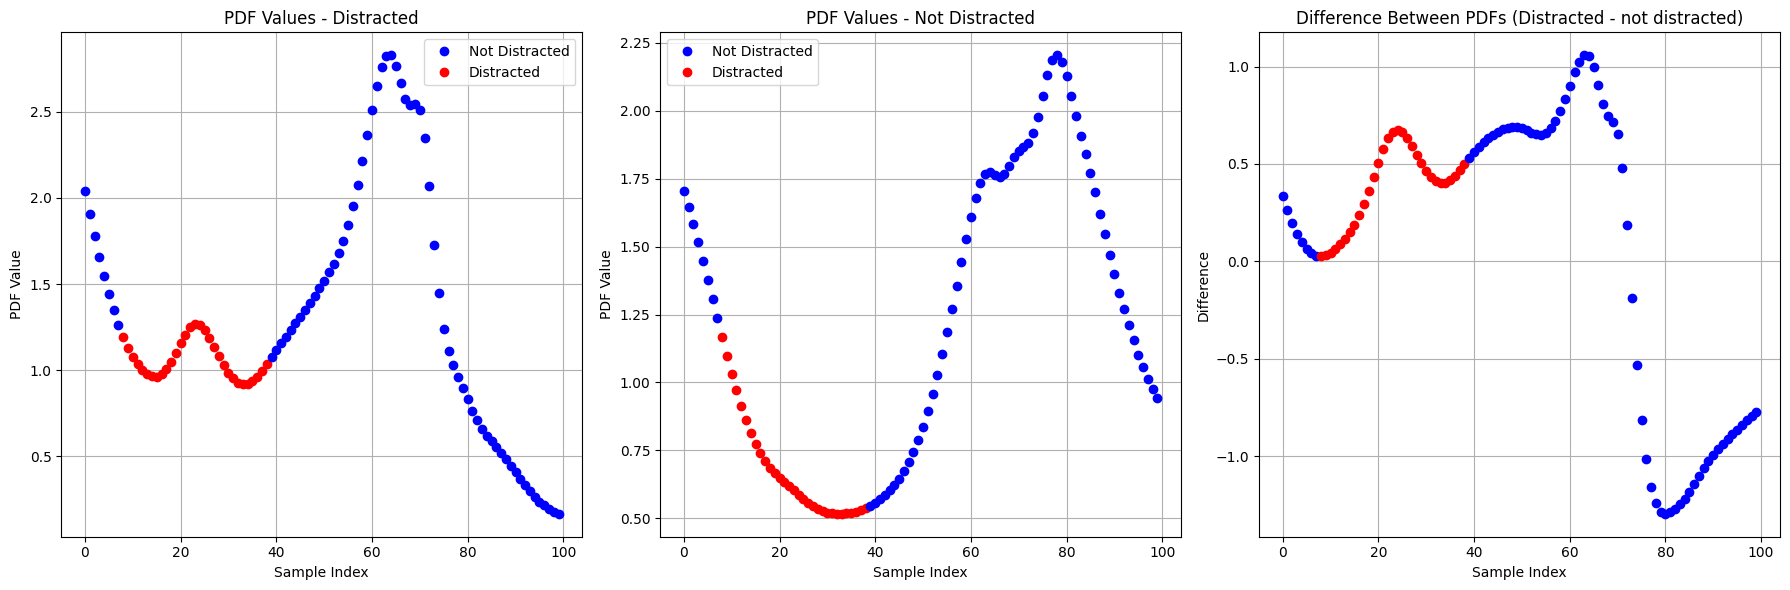

data_window.shape=(100, 2); tc_window.shape=(100,)


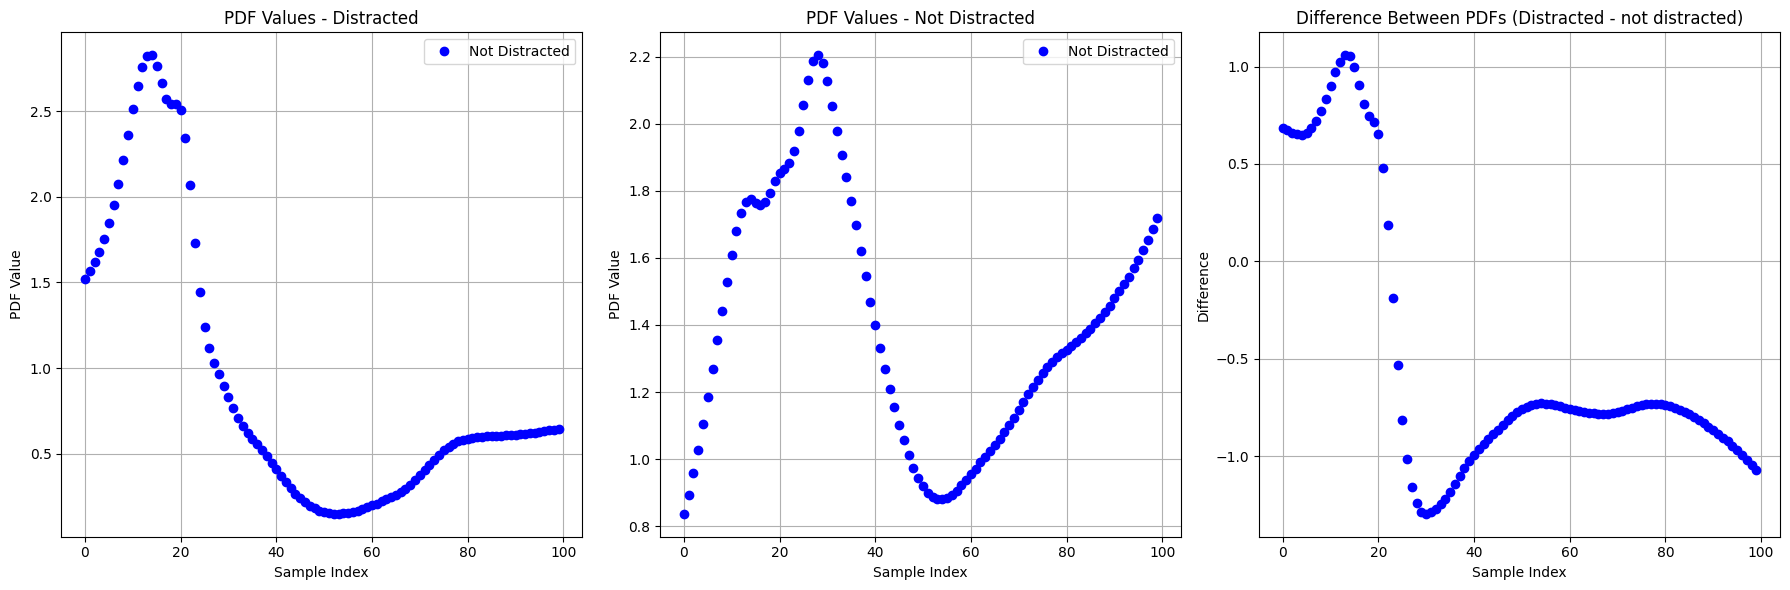

data_window.shape=(100, 2); tc_window.shape=(100,)


data_window.shape=(100, 2); tc_window.shape=(100,)


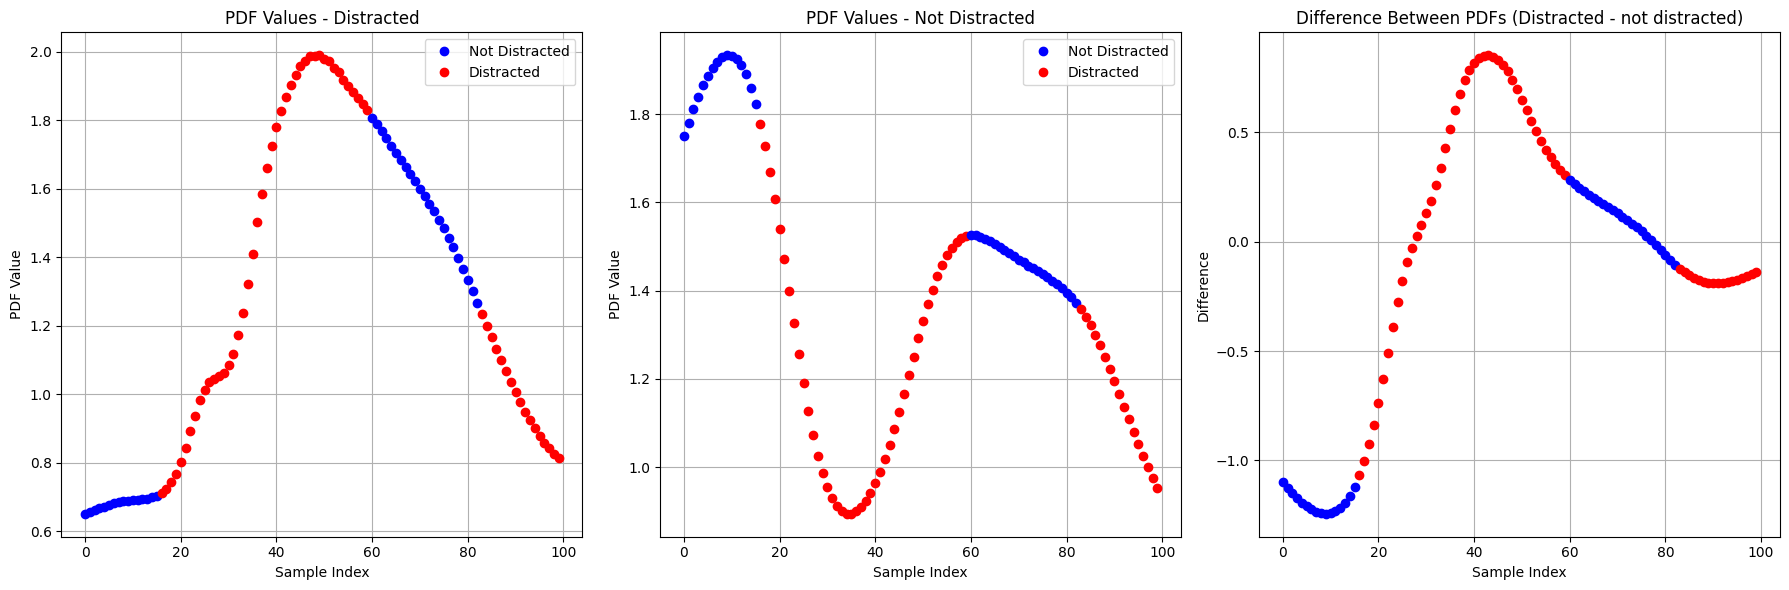

data_window.shape=(100, 2); tc_window.shape=(100,)


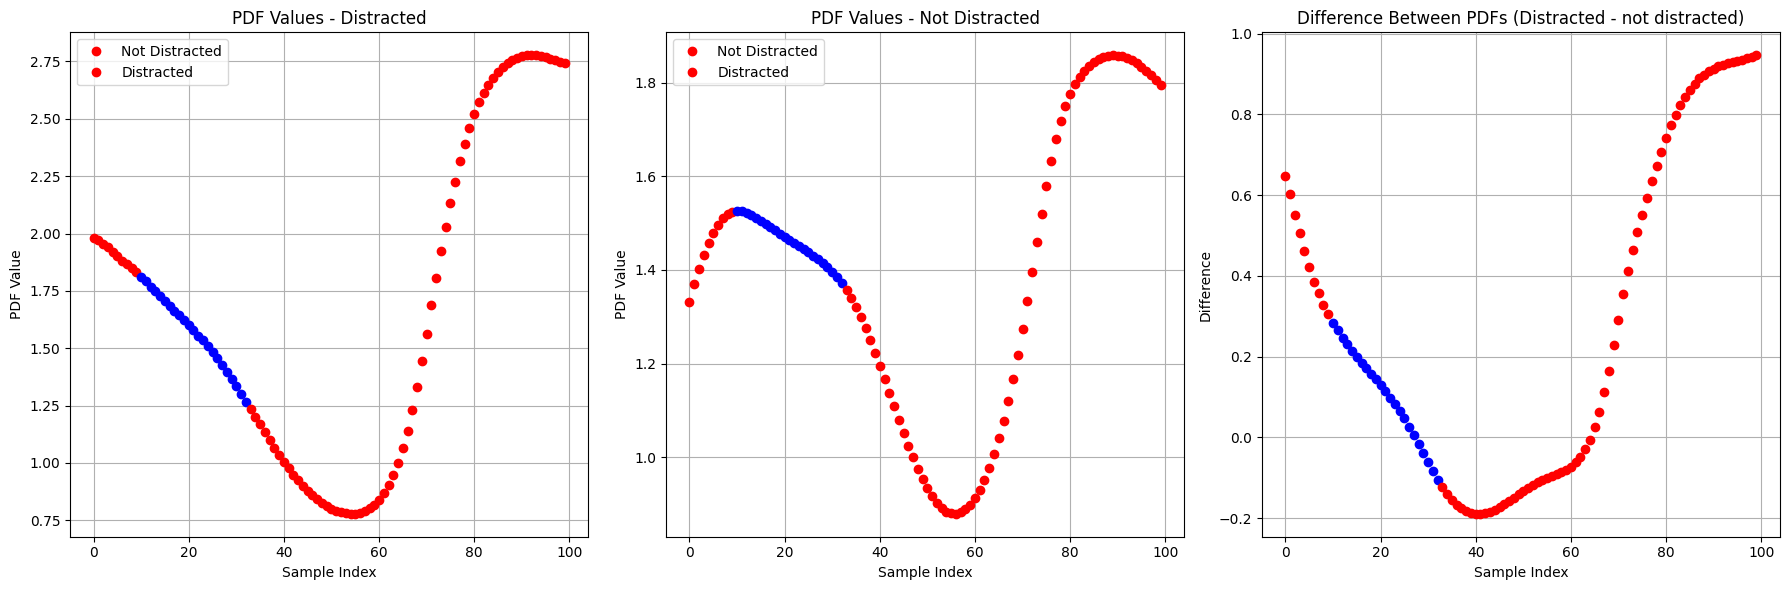

data_window.shape=(100, 2); tc_window.shape=(100,)


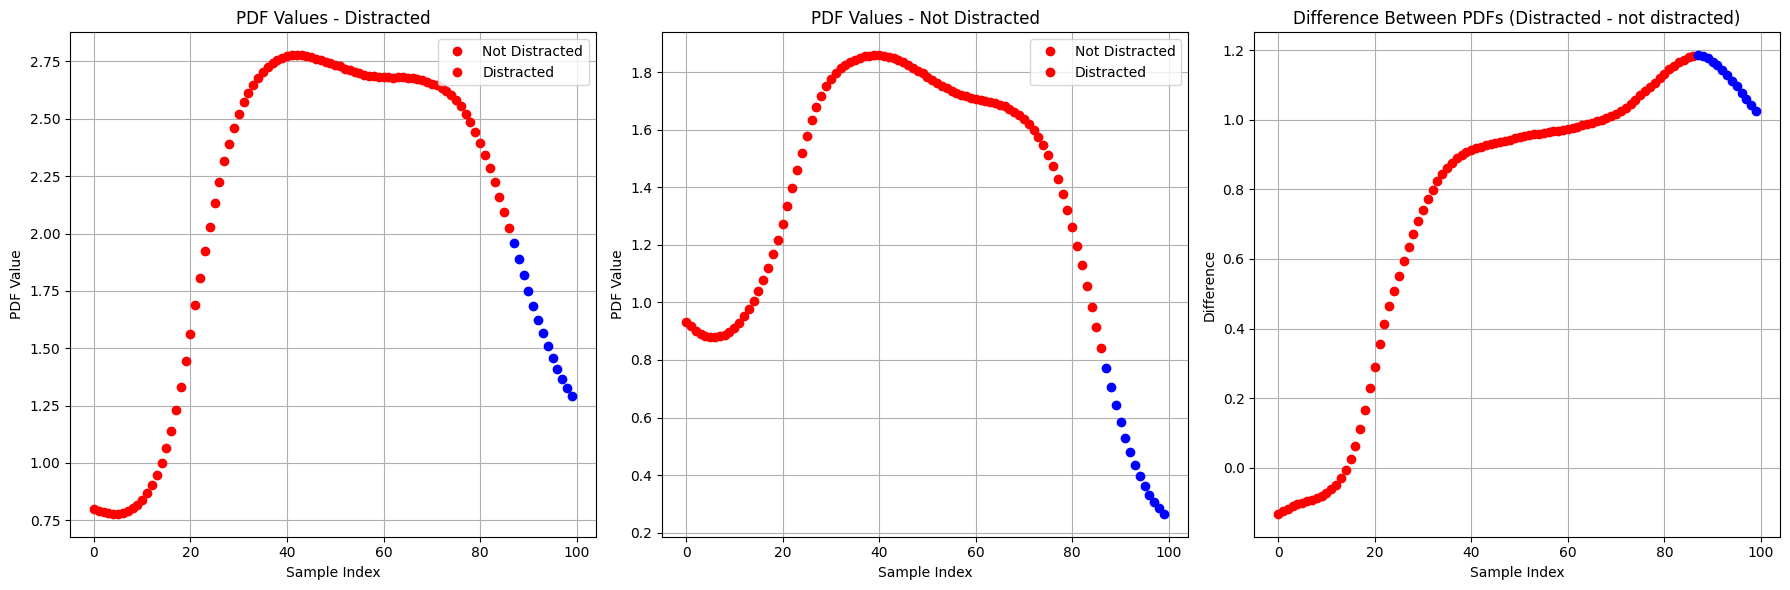

data_window.shape=(100, 2); tc_window.shape=(100,)


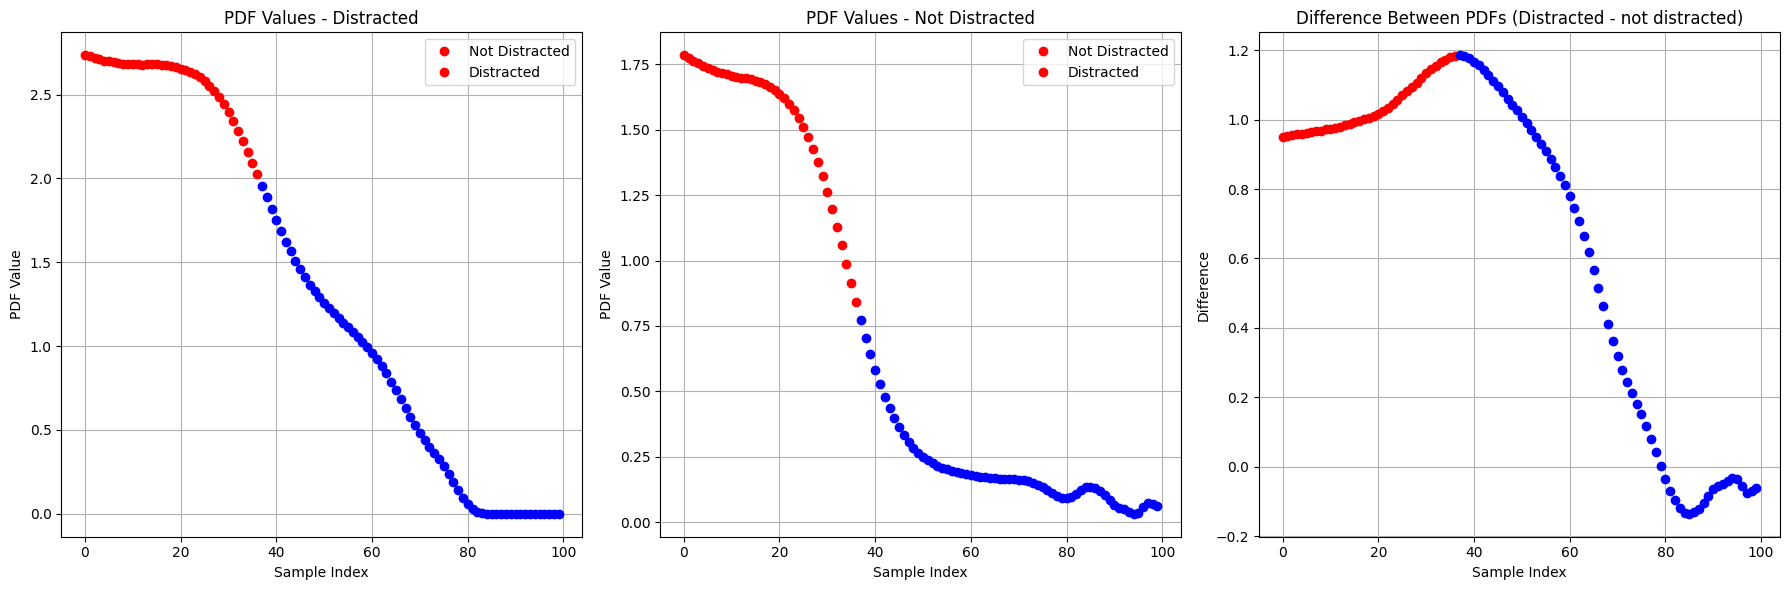

data_window.shape=(100, 2); tc_window.shape=(100,)


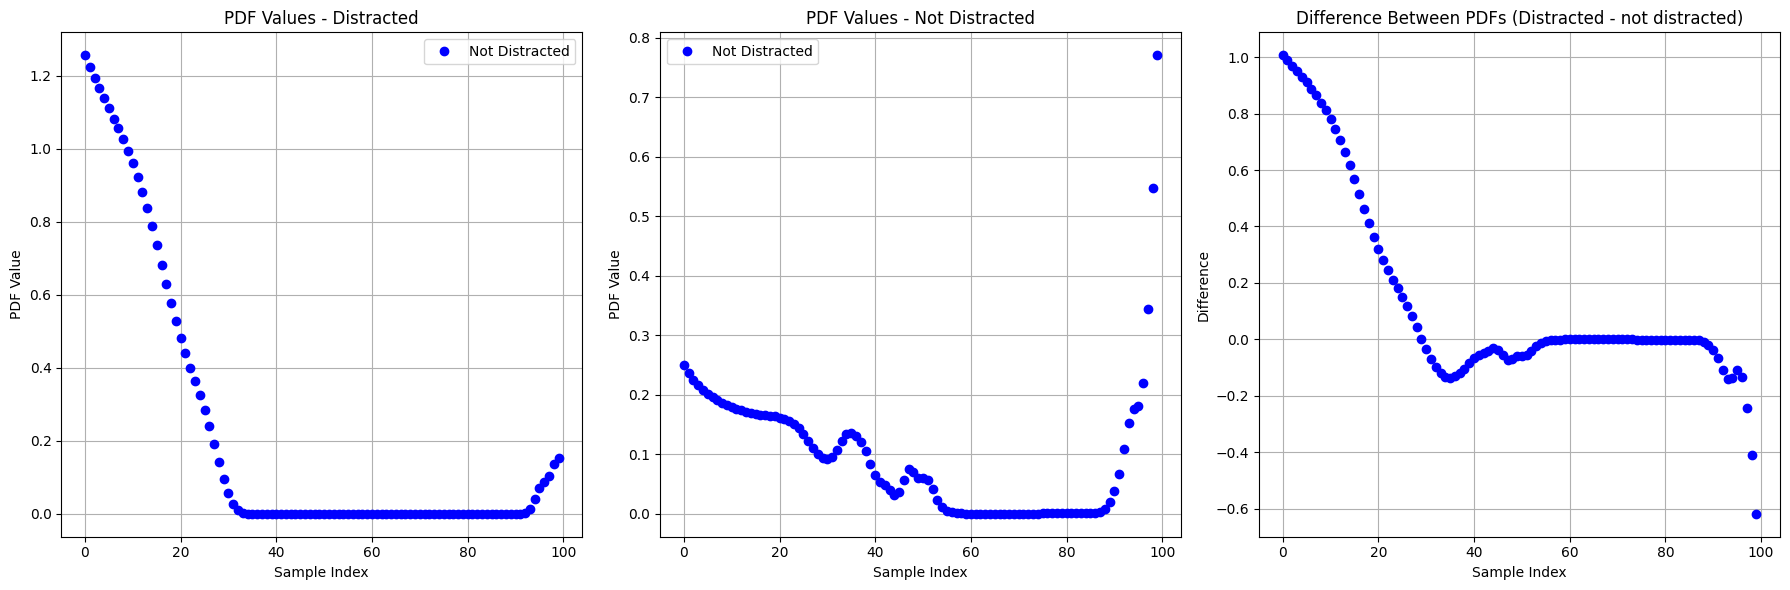

data_window.shape=(100, 2); tc_window.shape=(100,)


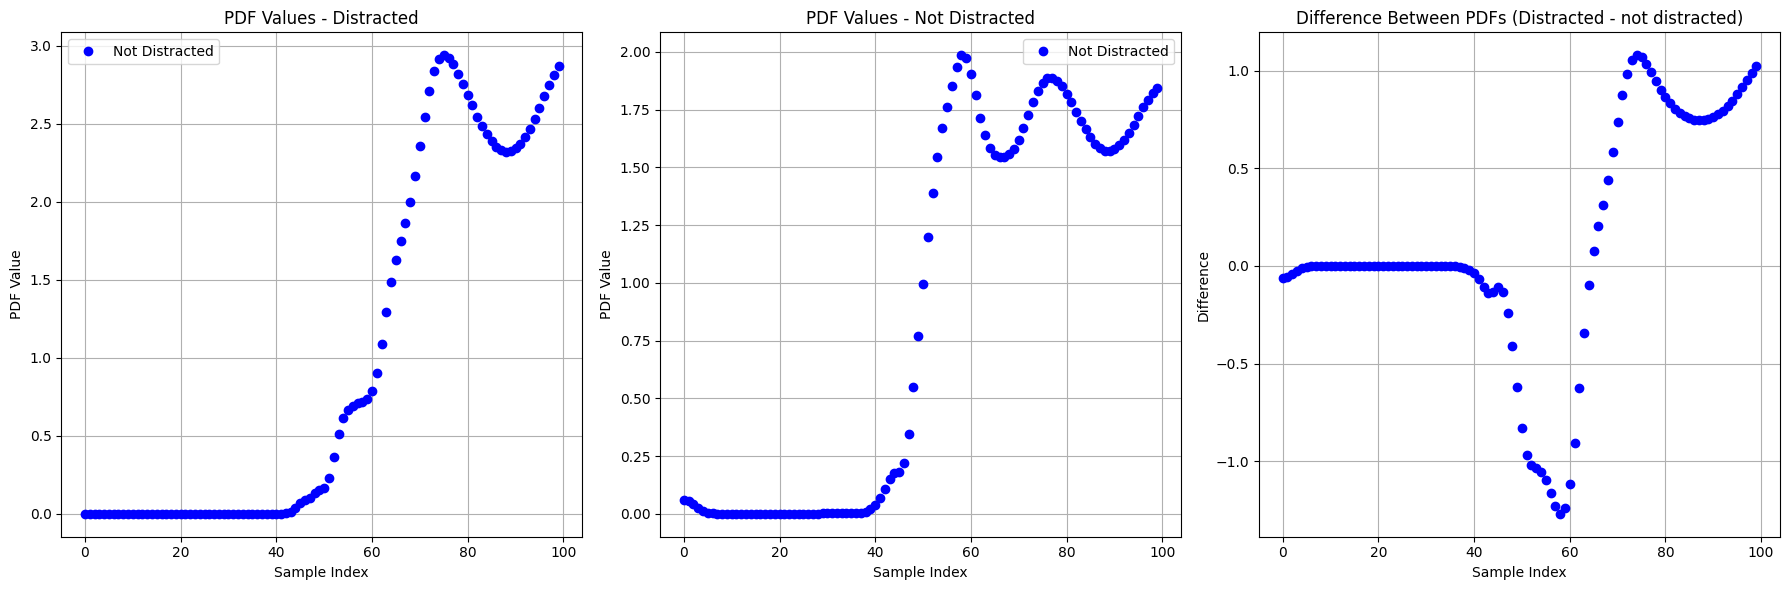

data_window.shape=(100, 2); tc_window.shape=(100,)


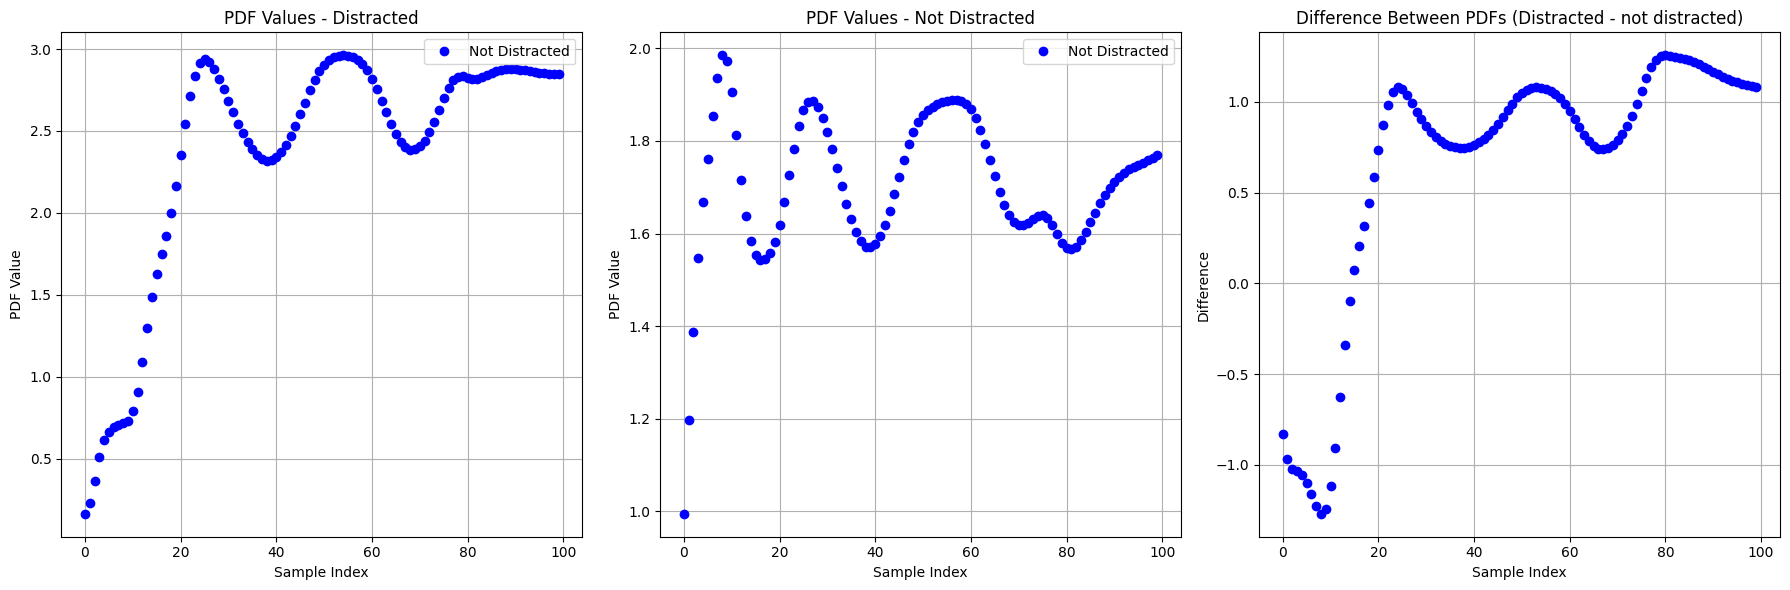

data_window.shape=(100, 2); tc_window.shape=(100,)


In [45]:
def classify_windows(data_windows, kde_distracted, kde_not_distracted):
    
    for idx, data_window in enumerate(data_windows):
        # Loop through each data window
        
        data_window = data_window[:, :, 0]  # Extract the relevant slice of the window
        tc_window = tc_windows[idx, :, 0]  # Corresponding tc_window

        print(f"{data_window.shape=}; {tc_window.shape=}")

        # Compute PDF values for both distracted and not-distracted
        pdf_values_distracted = np.exp(kde_distracted.score_samples(data_window))
        pdf_values_not_distracted = np.exp(kde_not_distracted.score_samples(data_window))

        # Compute the absolute difference between the two PDFs
        pdf_values_difference = np.abs(pdf_values_distracted - pdf_values_not_distracted)

        # Compute the absolute difference between the two PDFs
        pdf_values_difference = np.array(pdf_values_distracted) - np.array(pdf_values_not_distracted)

        # Set up side-by-side subplots (now 1 row, 3 columns for the difference plot)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

        # Create lists to keep track of plots for legend
        distract_legend_plots = []
        not_distract_legend_plots = []

        # Plot PDF values for distracted data
        for i, (pdf_value, tc_value) in enumerate(zip(pdf_values_distracted, tc_window)):
            color = 'b' if tc_value == 0 else 'r'
            plot = ax1.plot(i, pdf_value, marker='o', linestyle='', color=color)
            # Add plot for legend (only once per color)
            if tc_value == 0 and not distract_legend_plots:
                distract_legend_plots.append(plot[0])
            elif tc_value == 1 and len(distract_legend_plots) < 2:
                distract_legend_plots.append(plot[0])
        ax1.set_title("PDF Values - Distracted")
        ax1.set_xlabel("Sample Index")
        ax1.set_ylabel("PDF Value")
        ax1.grid(True)

        # Plot PDF values for not-distracted data
        for i, (pdf_value, tc_value) in enumerate(zip(pdf_values_not_distracted, tc_window)):
            color = 'b' if tc_value == 0 else 'r'
            plot = ax2.plot(i, pdf_value, marker='o', linestyle='', color=color)
            # Add plot for legend (only once per color)
            if tc_value == 0 and not not_distract_legend_plots:
                not_distract_legend_plots.append(plot[0])
            elif tc_value == 1 and len(not_distract_legend_plots) < 2:
                not_distract_legend_plots.append(plot[0])
        ax2.set_title("PDF Values - Not Distracted")
        ax2.set_xlabel("Sample Index")
        ax2.set_ylabel("PDF Value")
        ax2.grid(True)

        # Plot the absolute difference with color coding
        for i, (diff_value, tc_value) in enumerate(zip(pdf_values_difference, tc_window)):
            color = 'b' if tc_value == 0 else 'r'
            ax3.plot(i, diff_value, marker='o', linestyle='', color=color)

        ax3.set_title("Difference Between PDFs (Distracted - not distracted)")
        ax3.set_xlabel("Sample Index")
        ax3.set_ylabel("Difference")
        ax3.grid(True)

        # Adding legends
        ax1.legend(distract_legend_plots, ['Not Distracted', 'Distracted'], loc='best')
        ax2.legend(not_distract_legend_plots, ['Not Distracted', 'Distracted'], loc='best')

        # Show the side-by-side plot including the difference
        plt.tight_layout()
        plt.show()
    
classify_windows(data_window, kde_distracted, kde_not_distracted)